In [1]:
import pathlib
import numpy as np
from numpy import ma
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from dateutil.parser import parse as parse_date
import cv2 as cv
import scipy
from scipy import ndimage as ndi
from pyspectral.rsr_reader import RelativeSpectralResponse

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from tobac_flow.plotting import goes_figure, add_gl_ticks

# Filter some warnings because pyart doesn't work nicely with notebooks
import warnings
warnings.filterwarnings(
    action='ignore',
    category=DeprecationWarning
)

import warnings
warnings.filterwarnings(
    action='ignore',
    category=UserWarning
)

In [2]:
dpi=150
chapter_name = "chapter1"
save_format = "png"
save_path = pathlib.Path("../figures")
if not save_path.exists():
    save_path.mkdir()

figure_list = []

In [3]:
# Load example data
data_path = pathlib.Path("../data")
ds = xr.open_dataset(data_path / "chapter_1_example_data.nc")
bt = ds.BT
wvd = ds.WVD
swd = ds.SWD
rgb = ds.RGB
ref_grid = ds.nexrad_grid
glm_grid = ds.glm_grid
glm_flash_t = ds.glm_flash_t
glm_flash_x = ds.glm_flash_x
glm_flash_y = ds.glm_flash_y

theory_ds = xr.open_dataset(data_path / "chapter_1_theory_data.nc")
    

In [4]:
# Set colormaps for different fields
from cmcrameri import cm
cm_BT = cm.lajolla_r
cm_radar = cm.batlow
cm_lightning = cm.davos
cm_WVD = cm.devon
cm_SWD = cm.lapaz

## Figure 1: Examples of growing, mature and dissipating convection in satellite, radar and lightning signature

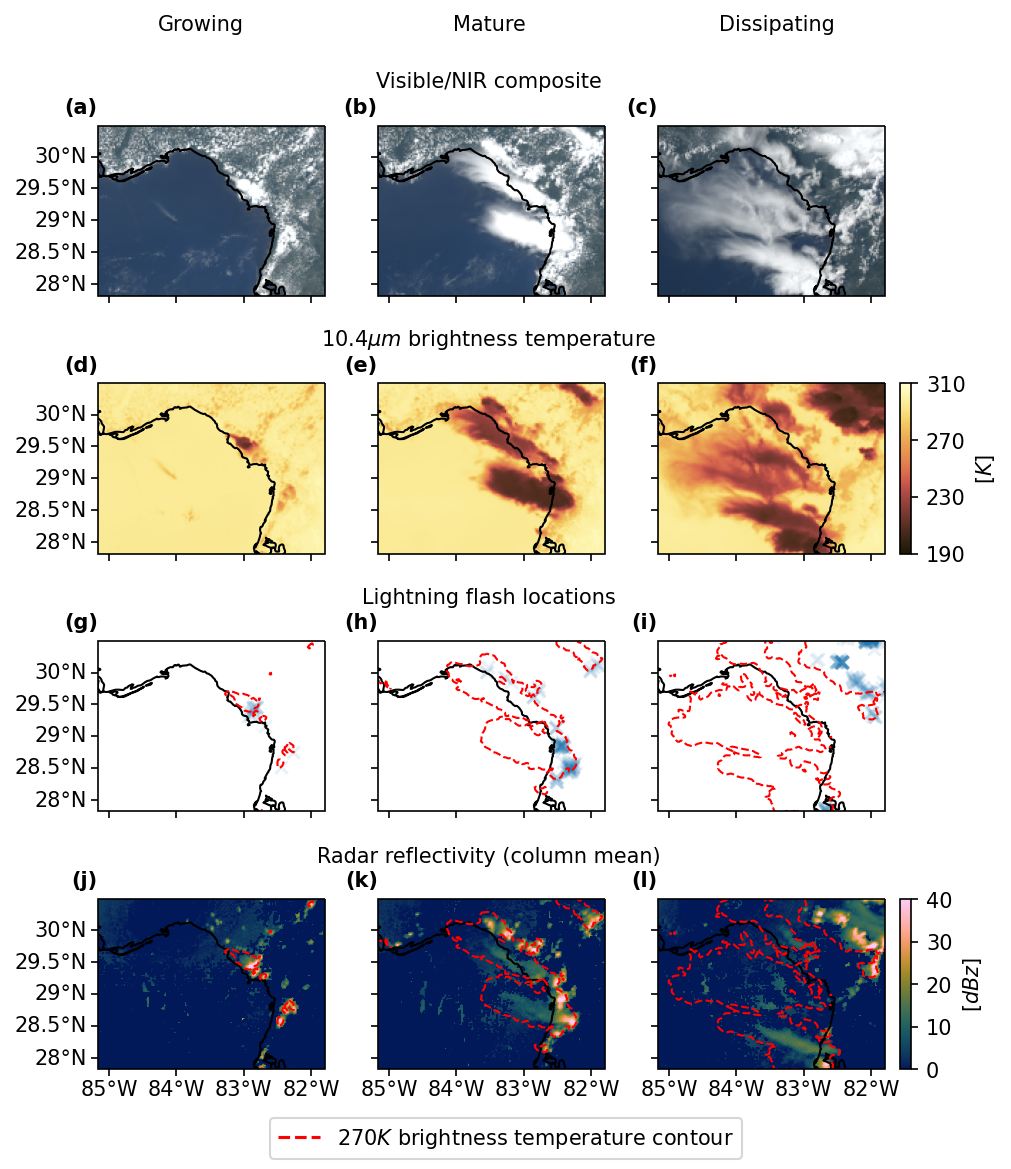

In [5]:
t0 = 0
t1 = 18
t2 = -1

x0, x1, y0, y1 = 1325-1300, 1485-1300, 730-600, 850-600

slice_dict = {"x":slice(x0,x1), "y":slice(y0,y1)}

fig = goes_figure(ds.isel(slice_dict), dpi=dpi, figsize=(6.4,8.4))

ax1 = fig.subplot(431)
ax1.coastlines()
ax1.imshow(rgb.isel({'t':t0}).isel(slice_dict))
ax1.set_title('(a)', loc='left', ha="right", weight="bold", fontsize=10)
gl = ax1.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


ax2 = fig.subplot(432)
ax2.coastlines()
ax2.imshow(rgb.isel({'t':t1}).isel(slice_dict))
ax2.set_title('(b)', loc='left', ha="right", weight="bold", fontsize=10)
# ax2.set_title('Mature')

ax3 = fig.subplot(433)
ax3.coastlines()
ax3.imshow(rgb.isel({'t':t2}).isel(slice_dict))
ax3.set_title('(c)', loc='left', ha="right", weight="bold", fontsize=10)
# ax3.set_title('Dissipating')

ax4 = fig.subplot(434)
ax4.coastlines()
ax4.imshow(bt[t0].isel(slice_dict), vmin=190, vmax=310, cmap=cm_BT)
ax4.set_title('(d)', loc='left', ha="right", weight="bold", fontsize=10)
gl = ax4.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax5 = fig.subplot(435)
ax5.coastlines()
ax5.imshow(bt[t1].isel(slice_dict), vmin=190, vmax=310, cmap=cm_BT)
ax5.set_title('(e)', loc='left', ha="right", weight="bold", fontsize=10)

ax6 = fig.subplot(436)
ax6.coastlines()
img = ax6.imshow(bt[t2].isel(slice_dict), vmin=190, vmax=310, cmap=cm_BT)
cbar = ax6.colorbar(img)
cbar.set_label('[$K$]')
cbar.set_ticks([190,230,270,310])
ax6.set_title('(f)', loc='left', ha="right", weight="bold", fontsize=10)

h = ds.goes_imager_projection.perspective_point_height
ax7 = fig.subplot(437)
ax7.coastlines()
ax7.set_title('(g)', loc='left', ha="right", weight="bold", fontsize=10)
ax7.contour(bt.isel({'t':t0}).isel(slice_dict), [270], colors=['r'], linestyles=['--'], linewidths=1)
wh = glm_flash_t == glm_grid.t[t0]
ax7.scatter(glm_flash_x[wh]*h, glm_flash_y[wh]*h, c=['C0'], marker='x', alpha=0.1)
# ax7.imshow(glm_grid[t0].coarsen({"x":5, "y":5}).sum()/5, vmin=0, vmax=10, cmap=cm_lightning)
gl = ax7.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax8 = fig.subplot(438)
ax8.coastlines()
ax8.set_title('(h)', loc='left', ha="right", weight="bold", fontsize=10)
ax8.contour(bt.isel({'t':t1}).isel(slice_dict), [270], colors=['r'], linestyles=['--'], linewidths=1)
wh = glm_flash_t == glm_grid.t[t1]
ax8.scatter(glm_flash_x[wh]*h, glm_flash_y[wh]*h, c=['C0'], marker='x', alpha=0.1)
# ax8.imshow(glm_grid[t1].coarsen({"x":5, "y":5}).sum()/5, vmin=0, vmax=10, cmap=cm_lightning)

ax9 = fig.subplot(439)
ax9.coastlines()
ax9.set_title('(i)', loc='left', ha="right", weight="bold", fontsize=10)
ax9.contour(bt.isel({'t':t2}).isel(slice_dict), [270], colors=['r'], linestyles=['--'], linewidths=1)
wh = glm_flash_t == glm_grid.t[t2]
ax9.scatter(glm_flash_x[wh]*h, glm_flash_y[wh]*h, c=['C0'], marker='x', alpha=0.1)
# img2 = ax9.imshow(glm_grid[t2].coarsen({"x":5, "y":5}).sum()/5, vmin=0, vmax=10, cmap=cm_lightning)
# cbar2 = ax9.colorbar(img2)
# cbar2.set_label('[flashes/minute]')

ax10 = fig.subplot(4, 3, 10)
ax10.coastlines()
ax10.set_title('(j)', loc='left', ha="right", weight="bold", fontsize=10)
ax10.contour(bt.isel({'t':t0}).isel(slice_dict), [270], colors=['r'], linestyles=['--'], linewidths=1)
ax10.imshow(ref_grid[t0].isel(slice_dict), vmin=0, vmax=40, cmap=cm_radar)
gl_ticks = ax10.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl_ticks.top_labels = False
gl_ticks.right_labels = False
gl_ticks.xlines = False
gl_ticks.ylines = False
gl_ticks.xformatter = LONGITUDE_FORMATTER
gl_ticks.yformatter = LATITUDE_FORMATTER

ax11 = fig.subplot(4, 3, 11)
ax11.coastlines()
ax11.set_title('(k)', loc='left', ha="right", weight="bold", fontsize=10)
ax11.contour(bt.isel({'t':t1}).isel(slice_dict), [270], colors=['r'], linestyles=['--'], linewidths=1)
ax11.imshow(ref_grid[t1].isel(slice_dict), vmin=0, vmax=40, cmap=cm_radar)
gl = ax11.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax12 = fig.subplot(4, 3, 12)
ax12.coastlines()
ax12.set_title('(l)', loc='left', ha="right", weight="bold", fontsize=10)
ax12.contour(bt.isel({'t':t2}).isel(slice_dict), [270], colors=['r'], linestyles=['--'], linewidths=1)
img3 = ax12.imshow(ref_grid[t2].isel(slice_dict), vmin=0, vmax=40, cmap=cm_radar)
cbar3 = ax12.colorbar(img3)
cbar3.set_label('[$dBz$]')
gl = ax12.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

fig.legend([mlines.Line2D([], [], color='r', linestyle='--')], 
           ['$270 K$ brightness temperature contour'], loc='lower center')

fig.text(0.51, 0.24, 'Radar reflectivity (column mean)', ha='center', va='baseline')
fig.text(0.51, 0.445, 'Lightning flash locations', ha='center', va='baseline')
fig.text(0.51, 0.65, '10.4$\mu m$ brightness temperature', ha='center', va='baseline')
fig.text(0.51, 0.855, 'Visible/NIR composite', ha='center', va='baseline')

fig.text(0.51, 0.9, 'Mature', ha='center', va='baseline')
fig.text(0.21, 0.9, 'Growing', ha='center', va='baseline')
fig.text(0.81, 0.9, 'Dissipating', ha='center', va='baseline')


plt.subplots_adjust(wspace=0., hspace=0.1, bottom=0.05, top=0.85, left=0.075, right=0.95)

plt.draw()
for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]:
    add_gl_ticks(ax, gl_ticks)

In [6]:
figure_list.append(fig)

Observations of a cluster of deep convective clouds over North-West
Florida throughout three stages of their lifecycle. This cluster of DCCs
occurred on the afternoon of 19th June 2018. The ”growing” column
were observed at 17:00 UTC, the ”mature” column at 19:00 UTC,
and the dissipating column at 21:00 UTC. Note that, unless otherwise
specified, this case study is used for all subsequent figures in this article

## Figure 2: DCC cross section in horizontal distance and time for satellite BT and radar reflectivity

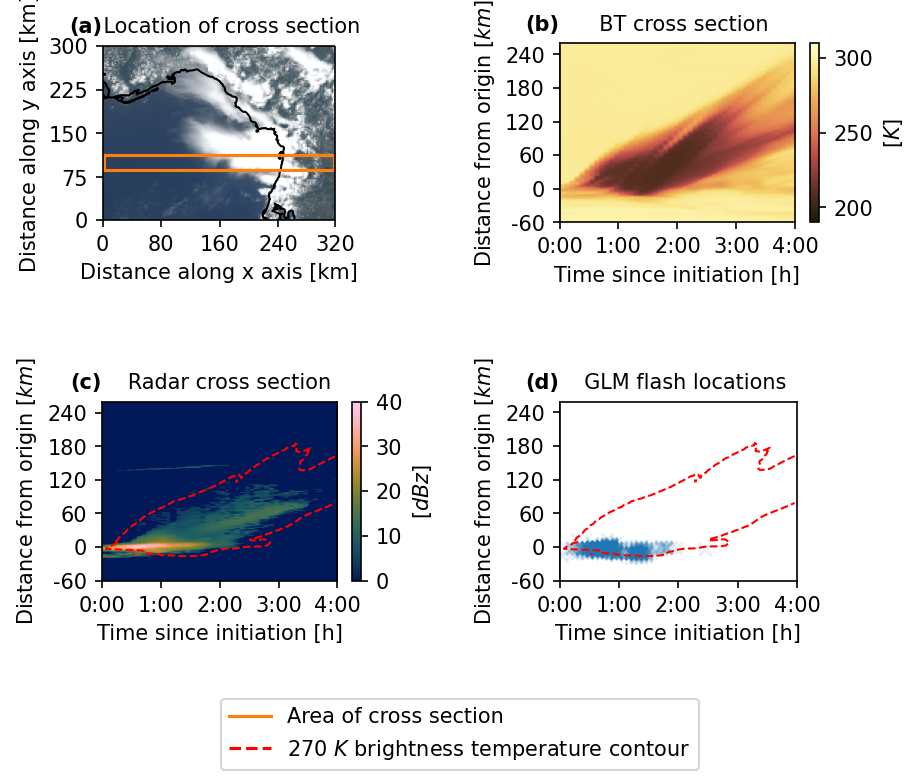

In [7]:
fig = goes_figure(ds.isel(slice_dict), dpi=dpi, figsize=(6.4,6))

yi0=75
yi1=85

y_slice = slice(yi0, yi1)

ax1 = fig.subplot(221)
ax1.imshow(rgb.isel({'t':24}).isel(slice_dict))
x0 = bt.isel(slice_dict).x.data[1]*ds.goes_imager_projection.perspective_point_height
x1 = bt.isel(slice_dict).x.data[-2]*ds.goes_imager_projection.perspective_point_height
y0 = bt.isel(slice_dict).y.data[yi0]*ds.goes_imager_projection.perspective_point_height
y1 = bt.isel(slice_dict).y.data[yi1]*ds.goes_imager_projection.perspective_point_height

ax1.plot([x0,x1,x1,x0,x0], [y0,y0,y1,y1,y0], 'C1')
ax1.coastlines()
plt.title('(a)', loc='left', ha="right", weight="bold", fontsize=10)
plt.title("    Location of cross section", fontsize=10)
ax1.set_xticks((bt.isel(slice_dict).x*ds.goes_imager_projection.perspective_point_height)[list(range(0,160,40))+[-1]])
ax1.set_xticklabels(np.arange(0,161,40)*2)
ax1.set_xlabel("Distance along x axis [km]", fontsize=10)
ax1.set_yticks((bt.isel(slice_dict).y*ds.goes_imager_projection.perspective_point_height)[list(range(0,120,30))+[-1]])
ax1.set_yticklabels((np.arange(0,121,30)[::-1]*2.5).astype(int))
ax1.set_ylabel("Distance along y axis [km]", fontsize=10)


ax2 = fig.subplot(222)

fig.legend([mlines.Line2D([], [], color='C1', linestyle='-'), mlines.Line2D([], [], color='r', linestyle='--')], 
           ['Area of cross section', '270 $K$ brightness temperature contour'], loc='lower center')

plt.subplots_adjust(wspace=0.6, bottom=0.15)


box = ax2.get_position()
ax2 = plt.axes([box.x0+box.width*0.09, box.y0+box.height*0.2, box.width*1.03, box.height*0.6])
plt.imshow(bt.isel(slice_dict).isel(y=y_slice).mean('y').T, cmap=cm_BT, vmin=190, vmax=310, aspect='auto', origin='upper')
cbar = plt.colorbar()
cbar.set_label('[$K$]')

plt.xticks([-0.5,11.5,23.5,35.5,47.5], labels=['0:00', '1:00', '2:00', '3:00', '4:00'])
plt.yticks(np.arange(159.5, 0,-30), labels=range(-60,250,60))
plt.title('(b)', loc='left', ha="right", weight="bold", fontsize=10)
plt.ylabel('Distance from origin [$km$]')
plt.xlabel('Time since initiation [h]')
plt.title('  BT cross section', fontsize=10)

ax3 = fig.subplot(223)
box = ax3.get_position()
ax3 = plt.axes([box.x0+box.width*0.09, box.y0+box.height*0.2, box.width*1.03, box.height*0.6])
plt.imshow(ref_grid.isel(slice_dict).isel(y=y_slice).mean('y').T, cmap=cm_radar, vmin=0, vmax=40, aspect='auto', origin='upper')
cbar = plt.colorbar()
cbar.set_label('[$dBz$]')
plt.contour(bt.isel(slice_dict).isel(y=y_slice).mean('y').T, [270], colors=['r'], linestyles=['--'], linewidths=[1])
plt.xticks([-0.5,11.5,23.5,35.5,47.5], labels=['0:00', '1:00', '2:00', '3:00', '4:00'])
plt.title('(c)', loc='left', ha="right", weight="bold", fontsize=10)
plt.yticks(np.arange(159.5, 0,-30), labels=range(-60,250,60))
plt.ylabel('Distance from origin [$km$]')
plt.xlabel('Time since initiation [h]')
plt.title('   Radar cross section', fontsize=10)

wh_lightning = np.logical_and.reduce([
    glm_flash_y < y0/h, glm_flash_y > y1/h, glm_flash_x > x0/h, glm_flash_x < x1/h
])
scatter_t = (glm_flash_t[wh_lightning]-bt.t[0]).astype(float)/3e11
scatter_x = ((glm_flash_x[wh_lightning]-(x0/h)) / ((x1-x0)/h) * 160)
ax4 = fig.subplot(224)
box = ax4.get_position()
ax4 = plt.axes([box.x0+box.width*0.09, box.y0+box.height*0.2, box.width*0.83, box.height*0.6])
ax4.scatter(scatter_t, scatter_x, c=['C0'], marker='x', alpha=0.1)
plt.contour(bt.isel(slice_dict).isel(y=y_slice).mean('y').T, [270], colors=['r'], linestyles=['--'], linewidths=[1])
plt.xticks([-0.5,11.5,23.5,35.5,47.5], labels=['0:00', '1:00', '2:00', '3:00', '4:00'])
plt.title('(d)', loc='left', ha="right", weight="bold", fontsize=10)
plt.yticks(np.arange(159.5, 0,-30), labels=range(-60,250,60))
plt.ylabel('Distance from origin [$km$]')
plt.xlabel('Time since initiation [h]')
plt.title('  GLM flash locations', fontsize=10)
ax4.invert_yaxis()



In [8]:
figure_list.append(fig)

Cross sections of the DCC observed in figure 4.1 as they develop over
time. a.: The location of the cross-section within the observed DCC.
The mean of values is taken in the North-South axis. b.: ABI 10.8 μm
brightness temperature, showing rapid cooling for the first 30 minutes,
followed by an expanding region of anvil cloud that begins to thin and
warm after 2-3 hours. c.: Column mean radar reflectivity, showing the
presence and location of the convective core. d.: Observed flash locations from GLM.Initiation occurred at
82.0°W 28.5°N at a time of 17:00 U

## Figure 3: GOES ABI imagery for channel 13, WVD, and SWD combinations

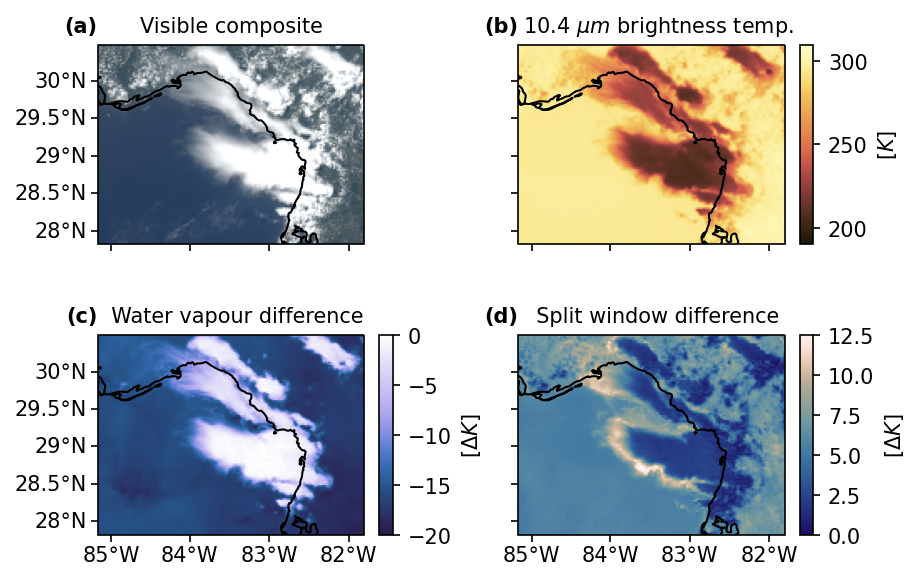

In [9]:
fig = goes_figure(ds.isel(slice_dict), dpi=dpi, figsize=(6.4,4.8))

ax1 = fig.subplot(221)
ax1.coastlines()
im1 = ax1.imshow(rgb[24].isel(slice_dict), cmap=cm_BT, vmin=190, vmax=310)
ax1.set_title('(a)', loc='left', ha="right", weight="bold", fontsize=10)
ax1.set_title('Visible composite', fontsize=10)
gl = ax1.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


ax2 = fig.subplot(222)
ax2.coastlines()
im2 = ax2.imshow(bt[24].isel(slice_dict), cmap=cm_BT, vmin=190, vmax=310)
cbar2 = ax2.colorbar(im1)
cbar2.set_label('[$K$]', fontsize=10)
# cbar1.set_ticks([190,230,270,310])
ax2.set_title('(b)', loc='left', ha="right", weight="bold", fontsize=10)
ax2.set_title('  10.4 $\mu m$ brightness temp.', fontsize=10)

ax3 = fig.subplot(223)
ax3.coastlines()
im2 = ax3.imshow(wvd[24].isel(slice_dict), cmap=cm_WVD, vmin=-20, vmax=0)
cbar2 = ax3.colorbar(im2)
cbar2.set_label('[$\Delta K$]', fontsize=10)
ax3.set_title('(c)', loc='left', ha="right", weight="bold", fontsize=10)
ax3.set_title('  Water vapour difference', fontsize=10)
gl_ticks = ax3.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl_ticks.top_labels = False
gl_ticks.right_labels = False
gl_ticks.xlines = False
gl_ticks.ylines = False
gl_ticks.xformatter = LONGITUDE_FORMATTER
gl_ticks.yformatter = LATITUDE_FORMATTER

ax4 = fig.subplot(224)
ax4.coastlines()
im3 = ax4.imshow(swd[24].isel(slice_dict), cmap=cm_SWD, vmin=0, vmax=12.5)
cbar3 = ax4.colorbar(im3)
cbar3.set_label('[$\Delta K$]', fontsize=10)
cbar3.ax.set_yticks(np.arange(0,13,2.5))
ax4.set_title('(d)', loc='left', ha="right", weight="bold", fontsize=10)
ax4.set_title('  Split window difference', fontsize=10)
gl = ax4.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.subplots_adjust(wspace=0.3, hspace=0.1)

plt.draw()
for ax in [ax1, ax2, ax3, ax4]:
    add_gl_ticks(ax, gl_ticks)

In [10]:
figure_list.append(fig)

ABI channels and channel differences used with the detection and
tracking algorithm. a.: A visible composite. b.: The 10.8 μm brightness temperature, or clean
longwave window channel, which can differentiate clouds at all alti-
tudes by their brightness temperature. c.: the water vapour difference
(WVD) combination, of the 6.2 μm upper troposphere water vapour
channel minus the 7.3 μm lower troposphere water vapour channel,
which is strongly negative for clear sky and low cloud, but approaches
positive values for thick, high clouds. d.: the split window difference
(SWD) combination of the 10.8 μm clean longwave window channel
minus the 12.3 μm dirty longwave window channel, which is near zero
for thick clouds, around 5 K for clear skies and approximately 10 K for
thin, ice clouds

## Figure 4: Vertical weighting profiles

Text(0.5, 0.98, 'ABI vertical weighting functions')

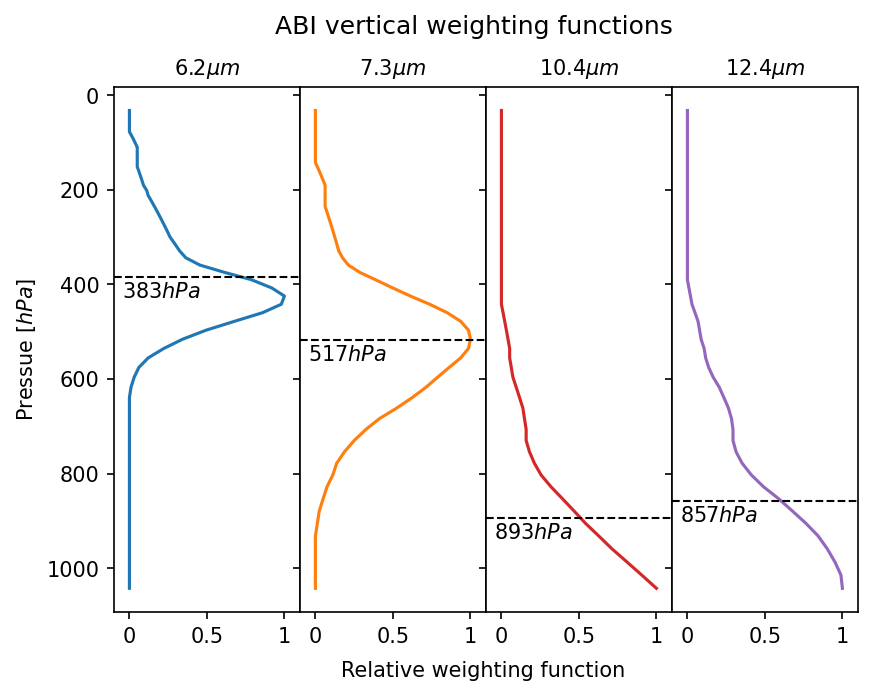

In [11]:
fig, axs = plt.subplots(1, 4, sharey=True, dpi=dpi)
fig.subplots_adjust(wspace=0)

colors = ["C0","C1","C3","C4"]
titles = ["$6.2 \mu m$", "$7.3 \mu m$", "$10.4 \mu m$", "$12.4 \mu m$"]
# Plot each graph, and manually set the y tick values
for i, ax in enumerate(axs):
    ax.plot(theory_ds.vertical_weighting_functions[i], theory_ds.pressure, colors[i])
    ax.set_xlim([-0.1, 1.1])
    ax.set_xticks([0,0.5,1], [0,0.5,1])
    ax.set_title(titles[i], fontsize=10)
    
    mean_pressure = np.average(theory_ds.pressure, weights=theory_ds.vertical_weighting_functions[i])
    ax.axhline(y=mean_pressure, color='k', linestyle="--", linewidth=1)
    ax.text(-0.05, mean_pressure+10, f'${mean_pressure:.0f} hPa$', ha="left", va="top")

ax.invert_yaxis()
axs[0].set_ylabel("Pressue [$hPa$]")

plt.subplots_adjust(bottom=0.15)

fig.text(0.51, 0.06, 'Relative weighting function', ha='center', va='baseline')

plt.suptitle("ABI vertical weighting functions", fontsize=12)

In [12]:
figure_list.append(fig)

Clear sky vertical weighting fucntions for the 6.2, 7.3, 10.4 and 12.4 micron ABI channels for rawinsonde profiles measured on 12:00:00 UTC 2020/08/10 at the Tampa RAOB station (KTBW - 72210). The dashed lines and associated pressure values show the weighted average emission height for each channel. Data from https://cimss.ssec.wisc.edu/goes-wf/plot-viewer/#/plot-viewer/plot/raob/abi16/default/20200810_1200Z/72210

## Figure 5: Core spectra for increasing core height

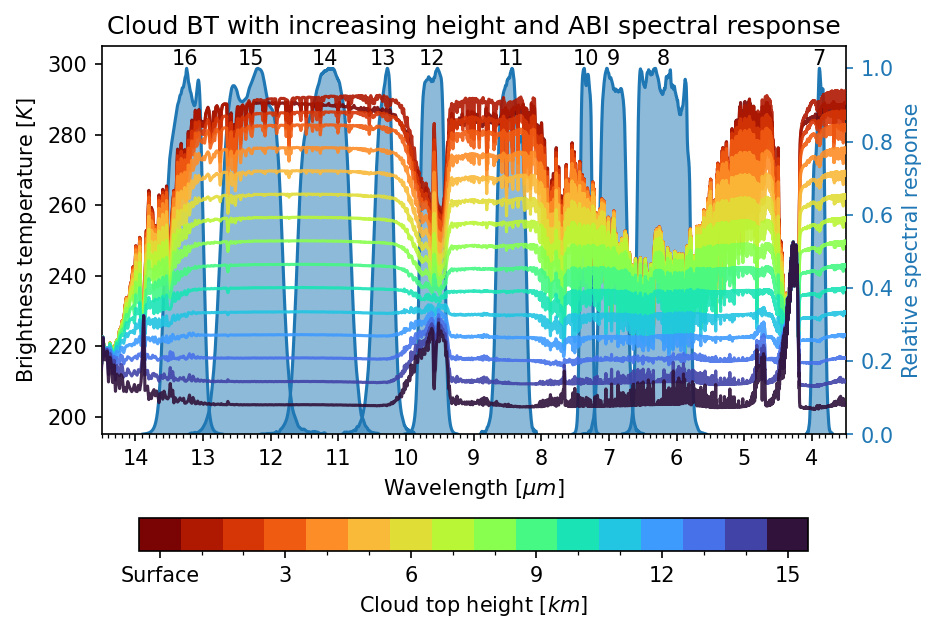

In [13]:
fig, ax1 = plt.subplots(dpi=dpi)

cmap = matplotlib.cm.turbo_r
bounds = np.arange(-0.5,16).tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

for i in range(theory_ds.height.size):
    ax1.plot(
        theory_ds.wavelength*1e9, 
        theory_ds.cloud_height_brightness_temperature[i],
        c=cmap(norm(i)), alpha=0.9
    )

plt.ylim([195,305])
plt.xticks((np.arange(3000,15001,1000)), np.arange(3,16))
ax1.xaxis.set_ticks(np.arange(3000,15001,100), minor=True)
plt.xlim((14500), (3500))
plt.xlabel("Wavelength [$\mu m$]")
plt.ylabel("Brightness temperature [$K$]")

ax2 = ax1.twinx()

abi_rsr = RelativeSpectralResponse('GOES-16', 'abi')

for band in ['ch7','ch8','ch9','ch10','ch11','ch12','ch13','ch14','ch15','ch16']:
    rsr = abi_rsr.rsr[band]["det-1"]
    plt.plot((rsr["wavelength"]*1e3), rsr["response"], "C0")
    plt.fill_between((rsr["wavelength"]*1e3), rsr["response"], facecolor="C0", alpha=0.5)
    plt.text((rsr["central_wavelength"]*1e3), 1.01, band[2:], ha="center")

plt.ylim([0,1.06])
plt.ylabel("Relative spectral response")
ax2.yaxis.label.set_color('C0')
ax2.tick_params(axis='y', colors='C0')

ax2.set_zorder(ax2.get_zorder()-1)
ax1.set_frame_on(False)
ax2.set_frame_on(True)

plt.title("Cloud BT with increasing height and ABI spectral response")

cbar = fig.colorbar(
    matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), 
    orientation="horizontal", label="Cloud top height [$km$]", 
    ax=plt.gca(), shrink=0.9, ticks=np.arange(0,16,3)
)
major_ticks = cbar.ax.xaxis.set_ticks(np.arange(0,16,3), ["Surface"] + np.arange(3,16,3).tolist())
minor_ticks = cbar.ax.xaxis.set_ticks(np.arange(0,16), minor=True)

In [14]:
figure_list.append(fig)

## Figure 6: Brightness temperature change with height

Text(0.5, 1.0, 'Brightness temperature with increasing cloud-top height')

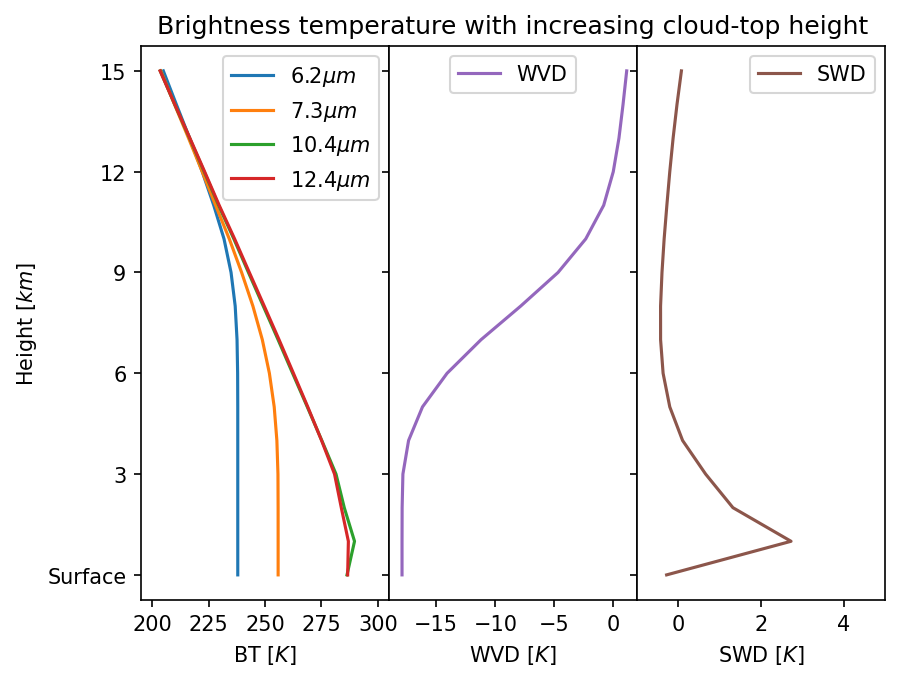

In [60]:
bt_funcs = []
for i in range(theory_ds.height.size):
    bt_funcs.append(scipy.interpolate.interp1d(
        theory_ds.wavelength, theory_ds.cloud_height_brightness_temperature[i]
    ))

bt_by_channel = {}
for band in ['ch7','ch8','ch9','ch10','ch11','ch12','ch13','ch14','ch15','ch16']:
    rsr = abi_rsr.rsr[band]["det-1"]
    wavelengths = rsr["wavelength"]/1e6
    srf = rsr["response"]
    bt_by_channel[band] = [np.average(bt(wavelengths), weights=srf) for bt in bt_funcs]

fig, axs = plt.subplots(1, 3, sharey=True, dpi=dpi)
fig.subplots_adjust(wspace=0)

wvd_height = np.array(bt_by_channel["ch8"]) - np.array(bt_by_channel["ch10"])
swd_height = np.array(bt_by_channel["ch13"]) - np.array(bt_by_channel["ch15"])

for i, band in enumerate(['ch8','ch10','ch13','ch15']):
    axs[0].plot(bt_by_channel[band], range(16))
axs[0].set_xlabel("BT [$K$]")
axs[0].legend(['$6.2\mu m$','$7.3\mu m$','$10.4\mu m$','$12.4\mu m$'])
axs[0].set_xticks([200,225,250,275, 300])
axs[0].set_xlim([195,305])

axs[1].plot(wvd_height, range(16), "C4")
axs[1].set_xlabel("WVD [$K$]")
axs[1].legend(["WVD"], loc="upper center")
axs[1].set_xticks(range(-15,1,5))
axs[1].set_xlim([-19,2])

axs[2].plot(swd_height, range(16), "C5")
axs[2].legend(["SWD"], loc="upper right")
axs[2].set_xlabel("SWD [$K$]")
axs[2].set_xlim([-1,5])

axs[0].set_yticks(np.arange(0,16,3), ["Surface"] + np.arange(3,16,3).tolist())
axs[0].set_ylabel("Height [$km$]")

axs[1].set_title("Brightness temperature with increasing cloud-top height", fontsize=12)

In [16]:
figure_list.append(fig)

## Figure 7: Cooling rates with height

Text(0.51, 0.1, 'Cloud top cooling rate [$K minute^{-1} / ms^{-1}$]')

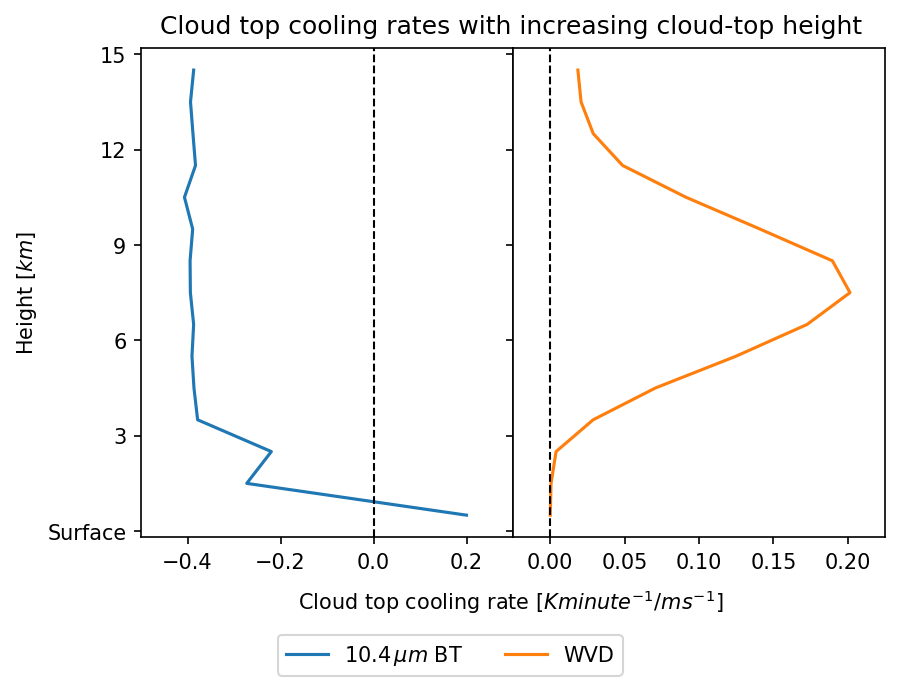

In [65]:
fig, axs = plt.subplots(1, 2, sharey=True, dpi=dpi)
fig.subplots_adjust(wspace=0)

bt_cooling = np.diff(
    np.array(bt_by_channel["ch13"])
) / 1000 * 60
wvd_cooling = np.diff(
    np.array(bt_by_channel["ch8"]) - np.array(bt_by_channel["ch10"])
) / 1000 * 60

axs[0].plot(bt_cooling, np.arange(0.5, 15))
axs[0].set_xlim([-0.5,0.3])
axs[0].axvline(x=0, color='k', linestyle="--", linewidth=1)

axs[1].plot(wvd_cooling, np.arange(0.5, 15), "C1")
axs[1].set_xlim([-0.025,0.225])
axs[1].axvline(x=0, color='k', linestyle="--", linewidth=1)

axs[0].set_yticks(np.arange(0,16,3), ["Surface"] + np.arange(3,16,3).tolist())
axs[0].set_ylabel("Height [$km$]")
plt.subplots_adjust(bottom=0.15)

fig.legend([mlines.Line2D([], [], color='C0'), mlines.Line2D([], [], color='C1')], 
           ["$10.4\,\mu m$ BT", "WVD"], loc='lower center', ncol=2)

plt.subplots_adjust(bottom=0.2)

fig.text(0.51, 0.9, "Cloud top cooling rates with increasing cloud-top height", ha="center", fontsize=12)
fig.text(0.51, 0.1, "Cloud top cooling rate [$K minute^{-1} / ms^{-1}$]", ha="center", fontsize=10)

In [18]:
figure_list.append(fig)

## Figure 8: Anvil spectra for decreasing OD

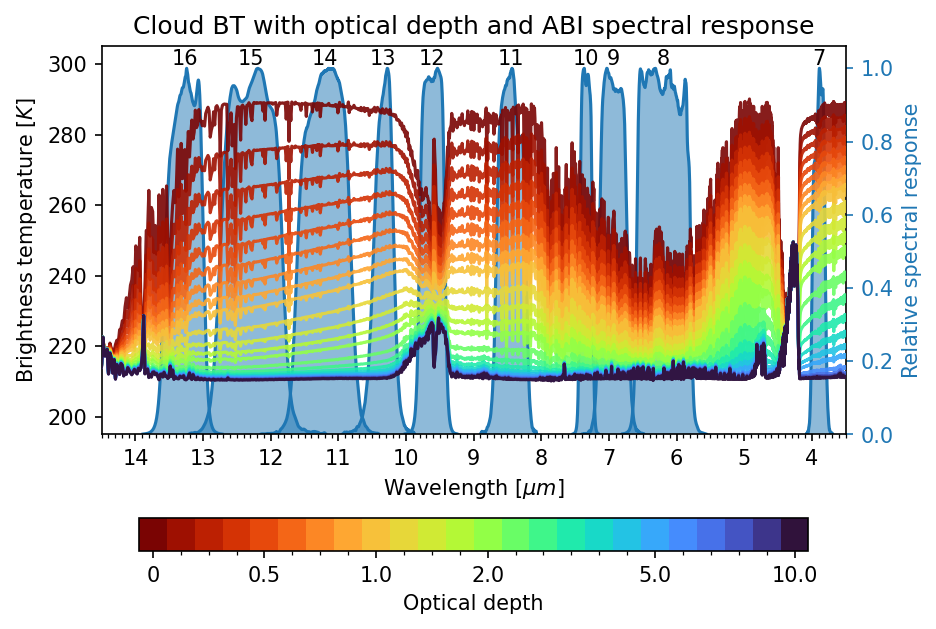

In [19]:
fig, ax1 = plt.subplots(dpi=dpi)

cmap = matplotlib.cm.turbo_r
bounds = np.arange(-0.5,theory_ds.optical_depth.size).tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

for i in range(theory_ds.optical_depth.size):
    ax1.plot(
        theory_ds.wavelength*1e9, 
        theory_ds.cloud_od_brightness_temperature[i],
        c=cmap(norm(i)), alpha=0.9
    )

plt.ylim([195,305])
plt.xticks((np.arange(3000,15001,1000)), np.arange(3,16))
ax1.xaxis.set_ticks(np.arange(3000,15001,100), minor=True)
plt.xlim((14500), (3500))
plt.xlabel("Wavelength [$\mu m$]")
plt.ylabel("Brightness temperature [$K$]")

ax2 = ax1.twinx()

abi_rsr = RelativeSpectralResponse('GOES-16', 'abi')

for band in ['ch7','ch8','ch9','ch10','ch11','ch12','ch13','ch14','ch15','ch16']:
    rsr = abi_rsr.rsr[band]["det-1"]
    plt.plot((rsr["wavelength"]*1e3), rsr["response"], "C0")
    plt.fill_between((rsr["wavelength"]*1e3), rsr["response"], facecolor="C0", alpha=0.5)
    plt.text((rsr["central_wavelength"]*1e3), 1.01, band[2:], ha="center")

plt.ylim([0,1.06])
plt.ylabel("Relative spectral response")
ax2.yaxis.label.set_color('C0')
ax2.tick_params(axis='y', colors='C0')

ax2.set_zorder(ax2.get_zorder()-1)
ax1.set_frame_on(False)
ax2.set_frame_on(True)

plt.title("Cloud BT with optical depth and ABI spectral response")

cbar = fig.colorbar(
    matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), 
    orientation="horizontal", label="Optical depth", 
    ax=plt.gca(), shrink=0.9
)
odticks = [0,4,8,12,18,23]
odlabels = [0] + [theory_ds.optical_depth.to_numpy()[i] for i in odticks[1:]]
major_ticks = cbar.ax.xaxis.set_ticks(odticks, odlabels)
minor_ticks = cbar.ax.xaxis.set_ticks(np.arange(0,theory_ds.optical_depth.size,1), minor=True)

In [20]:
figure_list.append(fig)

## Figure 9: Brightness temperature change with anvil OD

Text(0.5, 0, 'Optical depth')

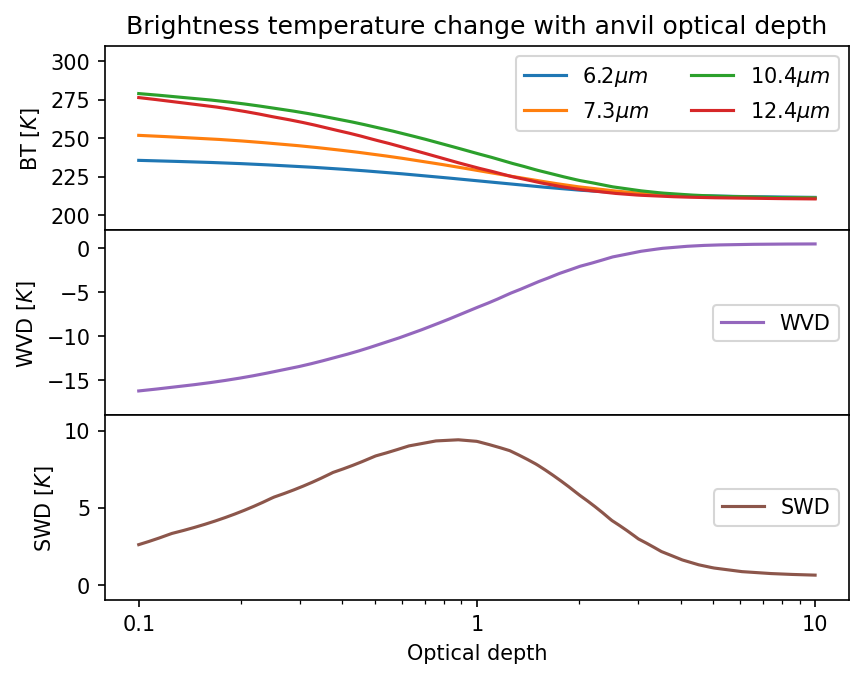

In [21]:
bt_funcs = []
for i in range(theory_ds.optical_depth.size):
    bt_funcs.append(scipy.interpolate.interp1d(
        theory_ds.wavelength, theory_ds.cloud_od_brightness_temperature[i]
    ))

bt_by_channel = {}
for band in ['ch7','ch8','ch9','ch10','ch11','ch12','ch13','ch14','ch15','ch16']:
    rsr = abi_rsr.rsr[band]["det-1"]
    wavelengths = rsr["wavelength"]/1e6
    srf = rsr["response"]
    bt_by_channel[band] = [np.average(bt(wavelengths), weights=srf) for bt in bt_funcs]

bt_od_func = {band:scipy.interpolate.interp1d(
    theory_ds.optical_depth, bt_by_channel[band]
) for band in ['ch8','ch10','ch13','ch15']}

fig, axs = plt.subplots(3, 1, sharex=True, dpi=dpi)
# Remove vertical space between axes
fig.subplots_adjust(hspace=0)

xlocs = np.linspace(np.log(0.1), np.log(10), 1000)
xvals = np.minimum(np.exp(xlocs), 10)
# Plot each graph, and manually set the y tick values
for i, band in enumerate(['ch8','ch10','ch13','ch15']):
    axs[0].plot(xlocs, bt_od_func[band](xvals))
axs[0].set_ylabel("BT [$K$]")
axs[0].legend(['$6.2\mu m$','$7.3\mu m$','$10.4\mu m$','$12.4\mu m$'], ncol=2)
axs[0].set_ylim([190,310])
axs[0].set_yticks(range(200,301,25))

wvd_od = bt_od_func["ch8"](xvals) - bt_od_func["ch10"](xvals)
axs[1].plot(xlocs, wvd_od,"C4")
axs[1].set_ylabel("WVD [$K$]")
axs[1].set_yticks(range(-15,1,5))
axs[1].set_ylim([-19,2])
axs[1].legend(["WVD"], loc="right")

swd_od = bt_od_func["ch13"](xvals) - bt_od_func["ch15"](xvals)
axs[2].plot(xlocs, swd_od,"C5")
axs[2].set_ylabel("SWD [$K$]")
axs[2].set_ylim([-1,11])
axs[2].legend(["SWD"], loc="right")

axs[0].set_title("Brightness temperature change with anvil optical depth")
plt.xticks([np.log(0.1), np.log(1), np.log(10)], [0.1, 1, 10])
plt.xticks(np.log(np.arange(0.1,1,0.1)).tolist() + np.log(np.arange(1,11,1)).tolist(), minor=True)
plt.xlabel("Optical depth")

In [22]:
figure_list.append(fig)

## Figure 10: Comparison of optical flow methods

In [23]:
from tobac_flow import flow
flow_methods = ["Farneback", "DIS", "DeepFlow", "SparseToDense", "PCA", "DualTVL1"]
flows = {fm:flow.create_flow(bt, model=fm) for fm in flow_methods}

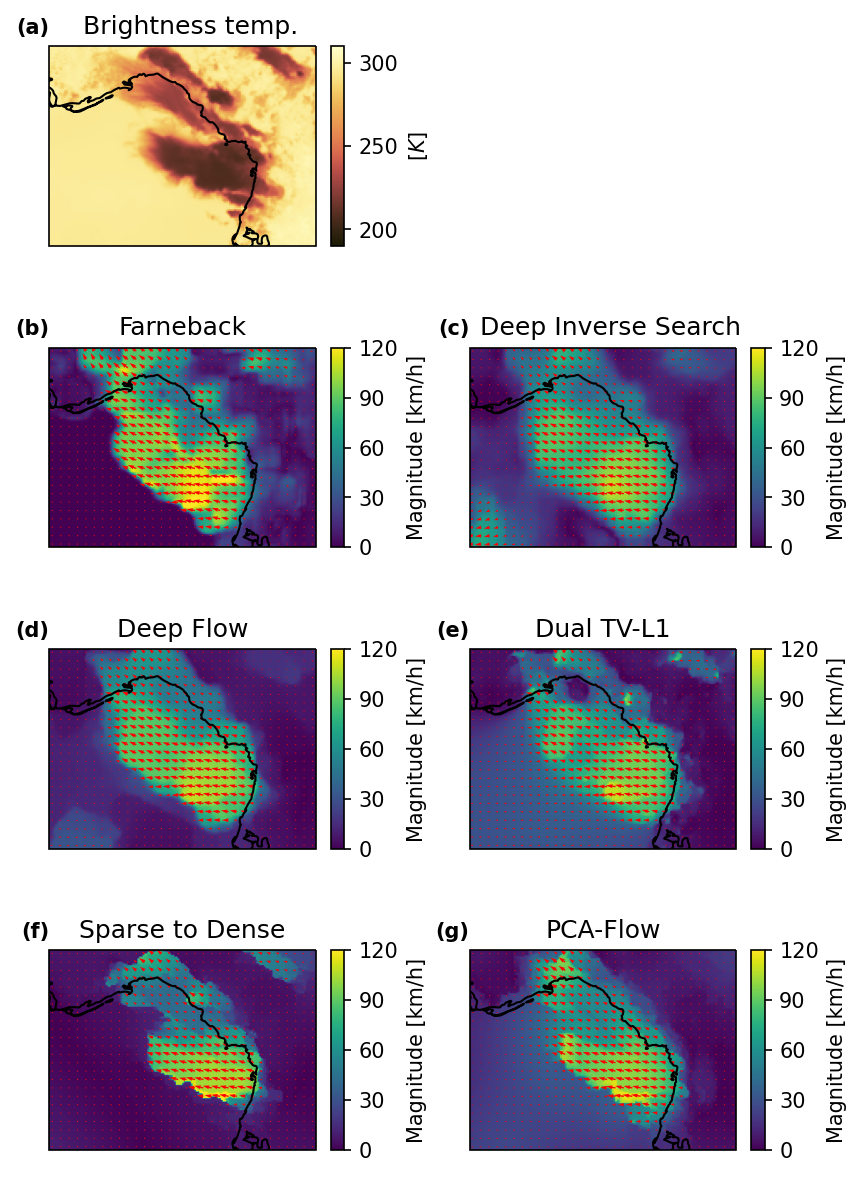

In [24]:
fig = goes_figure(ds.isel(slice_dict), figsize=(6.4, 10), dpi=dpi)

i = 24
x0, x1, y0, y1 = 1325-1300, 1485-1300, 730-600, 850-600

ax = fig.subplot(421)
ax.coastlines()
im = ax.imshow(bt[i].isel(slice_dict), cmap=cm_BT, vmin=190, vmax=310)
cbar = ax.colorbar(im)
cbar.set_label('[$K$]', fontsize=10)
ax.set_title('(a)', loc='left', ha="right", weight="bold", fontsize=10)
ax.set_title('  Brightness temp.', fontsize=12)

ax1 = fig.subplot(423)
ax1.coastlines()
img = ax1.imshow(flow.flow_magnitude(flows["Farneback"])[i,slice(y0,y1),slice(x0,x1)], vmin=0, vmax=4)
cbar = ax1.colorbar(img)
cbar.set_label('Magnitude [km/h]', fontsize=10)
cbar.ax.set_yticklabels([0,30,60,90,120])
q = ax1.quiver(
    flows["Farneback"].forward_flow[i,slice(y0,y1),slice(x0,x1),0], 
    -flows["Farneback"].forward_flow[i,slice(y0,y1),slice(x0,x1),1], 
    spacing=5, block_method="reduce", scale=100, width=0.005, color='r'
)
ax1.set_title('Farneback', fontsize=12)
ax1.set_title('(b)', loc='left', ha="right", weight="bold", fontsize=10)

ax2 = fig.subplot(424)
ax2.coastlines()
img = ax2.imshow(flow.flow_magnitude(flows["DIS"])[i,slice(y0,y1),slice(x0,x1)], vmin=0, vmax=4)
cbar = ax2.colorbar(img)
cbar.set_label('Magnitude [km/h]', fontsize=10)
cbar.ax.set_yticklabels([0,30,60,90,120])
q = ax2.quiver(
    flows["DIS"].forward_flow[i,slice(y0,y1),slice(x0,x1),0], 
    -flows["DIS"].forward_flow[i,slice(y0,y1),slice(x0,x1),1], 
    spacing=5, block_method="reduce", scale=100, width=0.005, color='r'
)
ax2.set_title('  Deep Inverse Search', fontsize=12)
ax2.set_title('(c)', loc='left', ha="right", weight="bold", fontsize=10)

ax3 = fig.subplot(425)
ax3.coastlines()
img = ax3.imshow(flow.flow_magnitude(flows["DeepFlow"])[i,slice(y0,y1),slice(x0,x1)], vmin=0, vmax=4)
cbar = ax3.colorbar(img)
cbar.set_label('Magnitude [km/h]', fontsize=10)
cbar.ax.set_yticklabels([0,30,60,90,120])
q = ax3.quiver(
    flows["DeepFlow"].forward_flow[i,slice(y0,y1),slice(x0,x1),0], 
    -flows["DeepFlow"].forward_flow[i,slice(y0,y1),slice(x0,x1),1], 
    spacing=5, block_method="reduce", scale=100, width=0.005, color='r'
)
ax3.set_title('Deep Flow', fontsize=12)
ax3.set_title('(d)', loc='left', ha="right", weight="bold", fontsize=10)

ax6 = fig.subplot(426)
ax6.coastlines()
img = ax6.imshow(flow.flow_magnitude(flows["DualTVL1"])[i,slice(y0,y1),slice(x0,x1)], vmin=0, vmax=4)
cbar = ax6.colorbar(img)
cbar.set_label('Magnitude [km/h]', fontsize=10)
cbar.ax.set_yticklabels([0,30,60,90,120])
q = ax6.quiver(
    flows["DualTVL1"].forward_flow[i,slice(y0,y1),slice(x0,x1),0], 
    -flows["DualTVL1"].forward_flow[i,slice(y0,y1),slice(x0,x1),1], 
    spacing=5, block_method="reduce", scale=100, width=0.005, color='r'
)
ax6.set_title('Dual TV-L1', fontsize=12)
ax6.set_title('(e)', loc='left', ha="right", weight="bold", fontsize=10)

ax4 = fig.subplot(427)
ax4.coastlines()
img = ax4.imshow(flow.flow_magnitude(flows["SparseToDense"])[i,slice(y0,y1),slice(x0,x1)], vmin=0, vmax=4)
cbar = ax4.colorbar(img)
cbar.set_label('Magnitude [km/h]', fontsize=10)
cbar.ax.set_yticklabels([0,30,60,90,120])
q = ax4.quiver(
    flows["SparseToDense"].forward_flow[i,slice(y0,y1),slice(x0,x1),0], 
    -flows["SparseToDense"].forward_flow[i,slice(y0,y1),slice(x0,x1),1], 
    spacing=5, block_method="reduce", scale=100, width=0.005, color='r'
)
ax4.set_title('Sparse to Dense', fontsize=12)
ax4.set_title('(f)', loc='left', ha="right", weight="bold", fontsize=10)

ax5 = fig.subplot(428)
ax5.coastlines()
img = ax5.imshow(flow.flow_magnitude(flows["PCA"])[i,slice(y0,y1),slice(x0,x1)], vmin=0, vmax=4)
cbar = ax5.colorbar(img)
cbar.set_label('Magnitude [km/h]', fontsize=10)
cbar.ax.set_yticklabels([0,30,60,90,120])
q = ax5.quiver(
    flows["PCA"].forward_flow[i,slice(y0,y1),slice(x0,x1),0], 
    -flows["PCA"].forward_flow[i,slice(y0,y1),slice(x0,x1),1], 
    spacing=5, block_method="reduce", scale=100, width=0.005, color='r'
)
ax5.set_title('PCA-Flow', fontsize=12)
ax5.set_title('(g)', loc='left', ha="right", weight="bold", fontsize=10)


plt.subplots_adjust(wspace=0.3)

In [25]:
figure_list.append(fig)

## Figure 11: Comparison of BT differences

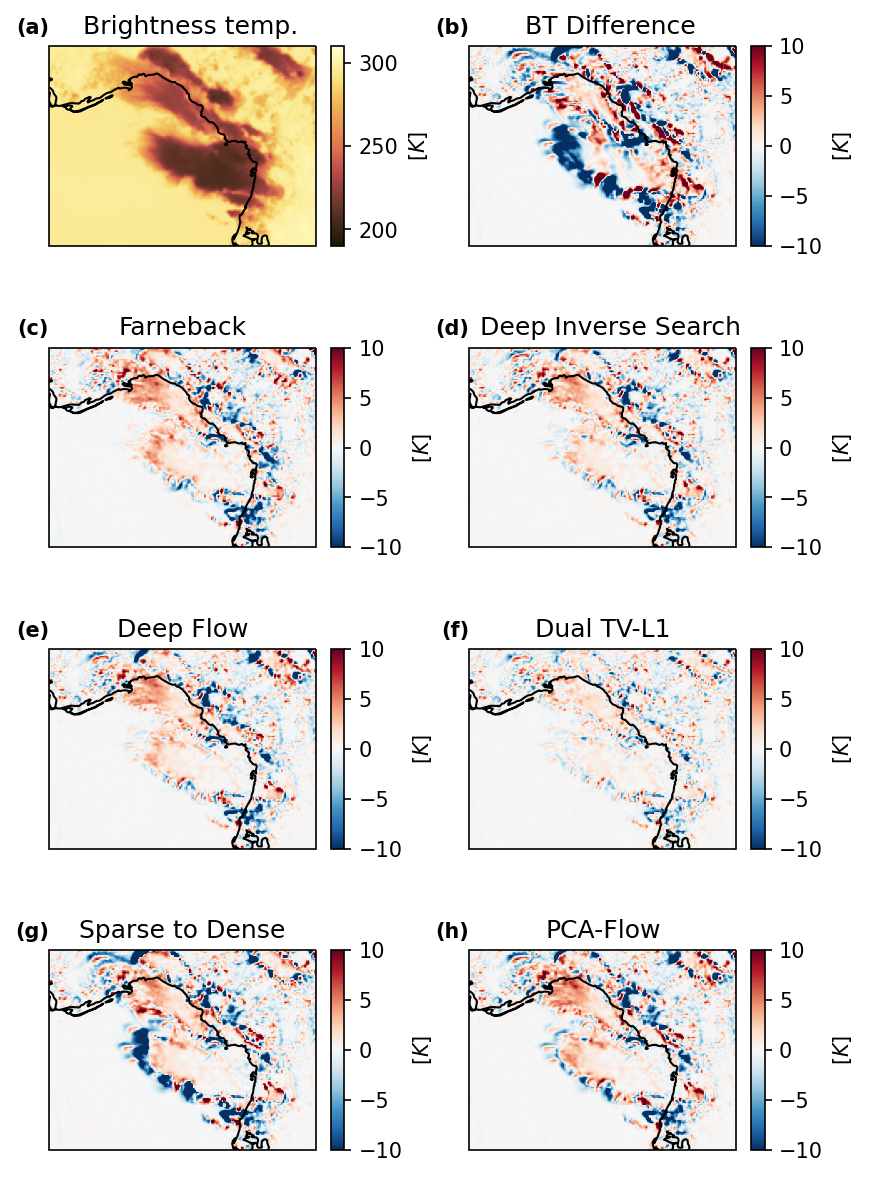

In [26]:
fig = goes_figure(ds.isel(slice_dict), figsize=(6.4, 10), dpi=dpi)

i = 24
x0, x1, y0, y1 = 1325-1300, 1485-1300, 730-600, 850-600

ax = fig.subplot(421)
ax.coastlines()
im = ax.imshow(bt[i].isel(slice_dict), cmap=cm_BT, vmin=190, vmax=310)
cbar = ax.colorbar(im)
cbar.set_label('[$K$]', fontsize=10)
ax.set_title('(a)', loc='left', ha="right", weight="bold", fontsize=10)
ax.set_title('  Brightness temp.', fontsize=12)

ax = fig.subplot(422)
ax.coastlines()
im = ax.imshow(bt[i+1].isel(slice_dict)-bt[i].isel(slice_dict), cmap="RdBu_r", vmin=-10, vmax=10)
cbar = ax.colorbar(im)
cbar.set_label('[$K$]', fontsize=10)
ax.set_title('(b)', loc='left', ha="right", weight="bold", fontsize=10)
ax.set_title('  BT Difference', fontsize=12)

ax1 = fig.subplot(423)
ax1.coastlines()
img = ax1.imshow(
    flow.get_forward_warp(bt, flows["Farneback"])[i,slice(y0,y1),slice(x0,x1)]-bt[i].isel(slice_dict), 
    cmap="RdBu_r", vmin=-10, vmax=10)
cbar = ax1.colorbar(img)
cbar.set_label('[$K$]', fontsize=10)
ax1.set_title('Farneback', fontsize=12)
ax1.set_title('(c)', loc='left', ha="right", weight="bold", fontsize=10)

ax2 = fig.subplot(424)
ax2.coastlines()
img = ax2.imshow(
    flow.get_forward_warp(bt, flows["DIS"])[i,slice(y0,y1),slice(x0,x1)]-bt[i].isel(slice_dict), 
    cmap="RdBu_r", vmin=-10, vmax=10)
cbar = ax2.colorbar(img)
cbar.set_label('[$K$]', fontsize=10)
ax2.set_title('  Deep Inverse Search', fontsize=12)
ax2.set_title('(d)', loc='left', ha="right", weight="bold", fontsize=10)

ax3 = fig.subplot(425)
ax3.coastlines()
img = ax3.imshow(
    flow.get_forward_warp(bt, flows["DeepFlow"])[i,slice(y0,y1),slice(x0,x1)]-bt[i].isel(slice_dict), 
    cmap="RdBu_r", vmin=-10, vmax=10)
cbar = ax3.colorbar(img)
cbar.set_label('[$K$]', fontsize=10)
ax3.set_title('Deep Flow', fontsize=12)
ax3.set_title('(e)', loc='left', ha="right", weight="bold", fontsize=10)

ax6 = fig.subplot(426)
ax6.coastlines()
img = ax6.imshow(
    flow.get_forward_warp(bt, flows["DualTVL1"])[i,slice(y0,y1),slice(x0,x1)]-bt[i].isel(slice_dict), 
    cmap="RdBu_r", vmin=-10, vmax=10)
cbar = ax6.colorbar(img)
cbar.set_label('[$K$]', fontsize=10)
ax6.set_title('Dual TV-L1', fontsize=12)
ax6.set_title('(f)', loc='left', ha="right", weight="bold", fontsize=10)

ax4 = fig.subplot(427)
ax4.coastlines()
img = ax4.imshow(
    flow.get_forward_warp(bt, flows["SparseToDense"])[i,slice(y0,y1),slice(x0,x1)]-bt[i].isel(slice_dict), 
    cmap="RdBu_r", vmin=-10, vmax=10)
cbar = ax4.colorbar(img)
cbar.set_label('[$K$]', fontsize=10)
ax4.set_title('Sparse to Dense', fontsize=12)
ax4.set_title('(g)', loc='left', ha="right", weight="bold", fontsize=10)

ax5 = fig.subplot(428)
ax5.coastlines()
img = ax5.imshow(
    flow.get_forward_warp(bt, flows["PCA"])[i,slice(y0,y1),slice(x0,x1)]-bt[i].isel(slice_dict), 
    cmap="RdBu_r", vmin=-10, vmax=10)
cbar = ax5.colorbar(img)
cbar.set_label('[$K$]', fontsize=10)
ax5.set_title('PCA-Flow', fontsize=12)
ax5.set_title('(h)', loc='left', ha="right", weight="bold", fontsize=10)


plt.subplots_adjust(wspace=0.3)

In [27]:
figure_list.append(fig)

## Figure 12: Flow difference and residual vector MSE

In [72]:
chapter1_flow_ds = xr.load_dataset(data_path / "chapter_1_flow_data.nc")
diff_mse = chapter1_flow_ds["diff_mse"].to_numpy()
vector_mse = chapter1_flow_ds["vector_mse"].to_numpy()
flow_time = chapter1_flow_ds["flow_time"].to_numpy()

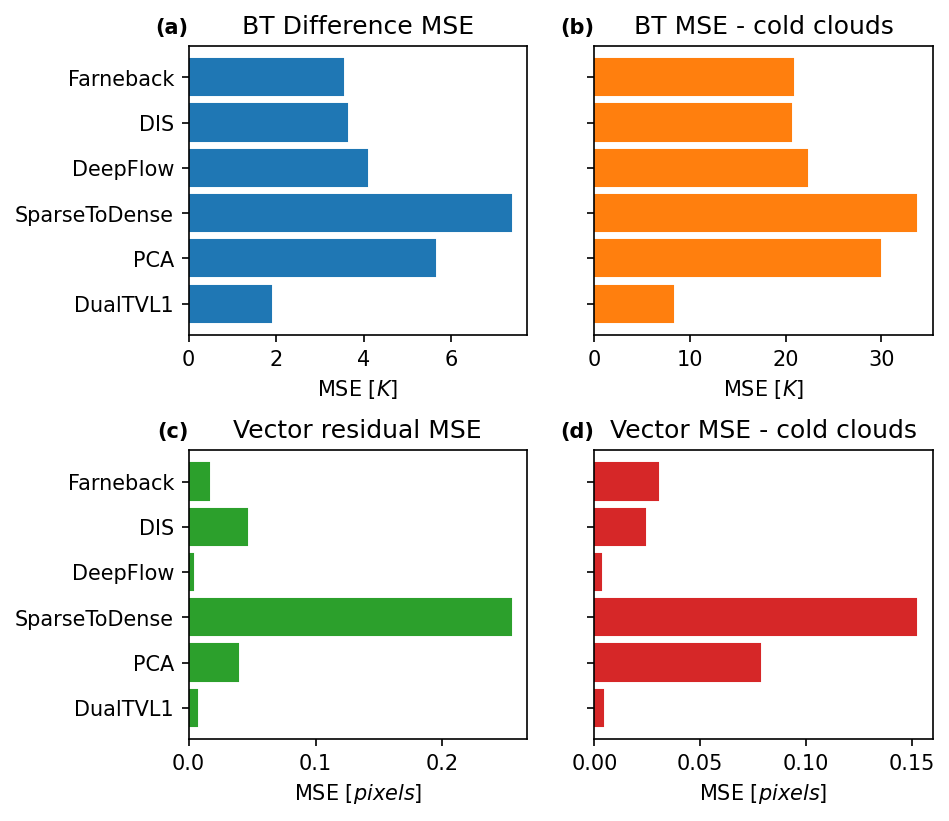

In [73]:
fig, axs = plt.subplots(2,2,dpi=dpi, figsize=(6.4,6))

axs[0,0].barh(range(len(flow_methods)), [mse[0] for mse in diff_mse], facecolor = 'C0', edgecolor='C0')
axs[0,0].set_yticks(range(len(flow_methods)), flow_methods)
axs[0,0].invert_yaxis()
axs[0,0].set_xlabel("MSE [$K$]")
axs[0,0].set_title("BT Difference MSE")
axs[0,0].set_title('(a)', loc='left', ha="right", weight="bold", fontsize=10)

axs[0,1].barh(range(len(flow_methods)), [mse[1] for mse in diff_mse], facecolor = 'C1', edgecolor='C1')
axs[0,1].set_yticks(range(len(flow_methods)), [""]*len(flow_methods))
axs[0,1].invert_yaxis()
axs[0,1].set_xlabel("MSE [$K$]")
axs[0,1].set_title("BT MSE - cold clouds")
axs[0,1].set_title('(b)', loc='left', ha="right", weight="bold", fontsize=10)

axs[1,0].barh(range(len(flow_methods)), [mse[0] for mse in vector_mse], facecolor = 'C2', edgecolor='C2')
axs[1,0].set_yticks(range(len(flow_methods)), flow_methods)
axs[1,0].invert_yaxis()
axs[1,0].set_xlabel("MSE [$pixels$]")
axs[1,0].set_title("Vector residual MSE")
axs[1,0].set_title('(c)', loc='left', ha="right", weight="bold", fontsize=10)

axs[1,1].barh(range(len(flow_methods)), [mse[1] for mse in vector_mse], facecolor = 'C3', edgecolor='C3')
axs[1,1].set_yticks(range(len(flow_methods)), [""]*len(flow_methods))
axs[1,1].invert_yaxis()
axs[1,1].set_xlabel("MSE [$pixels$]")
axs[1,1].set_title("Vector MSE - cold clouds")
axs[1,1].set_title('(d)', loc='left', ha="right", weight="bold", fontsize=10)

plt.subplots_adjust(hspace=0.4)

In [30]:
figure_list.append(fig)

## Figure 13: Flow vector performance

Text(0.5, 1.0, 'Flow method performance')

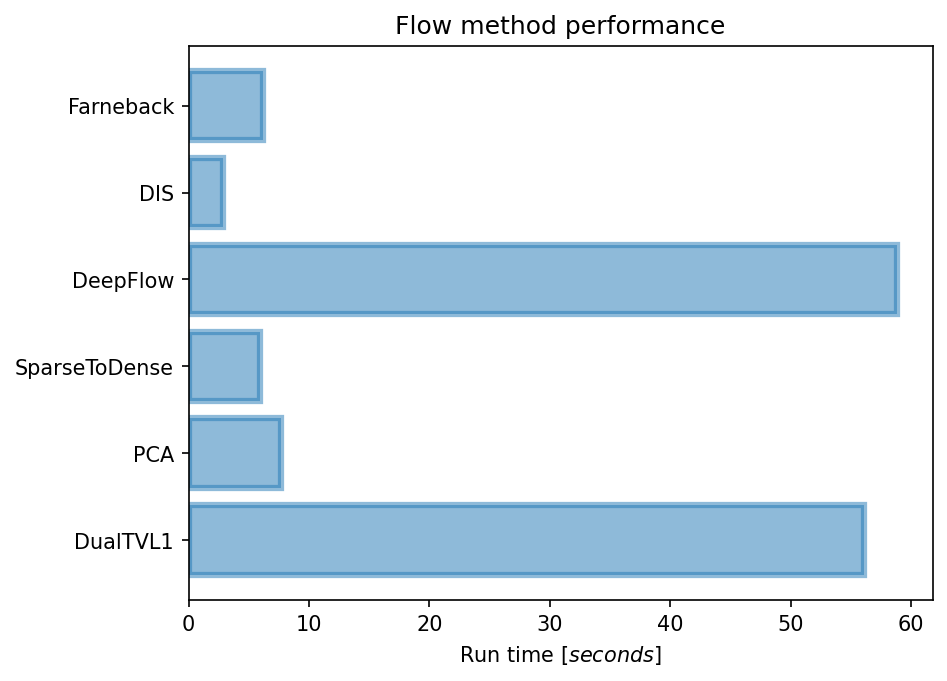

In [74]:
fig, ax = plt.subplots(1, 1, dpi=dpi)
ax.barh(range(len(flow_methods)), flow_time, facecolor = 'C0', edgecolor='C0', alpha=0.5, ls='solid', lw=3)
ax.set_yticks(range(len(flow_methods)), flow_methods)
ax.invert_yaxis()
ax.set_xlabel("Run time [$seconds$]")
ax.set_title("Flow method performance")


In [33]:
figure_list.append(fig)

## Figure 14: Residual flow error distribution

In [34]:
flow_residual_vectors = flow.get_flow_residual(bt, flows["Farneback"], model="Farneback")

Text(0, 0.5, 'Proportion')

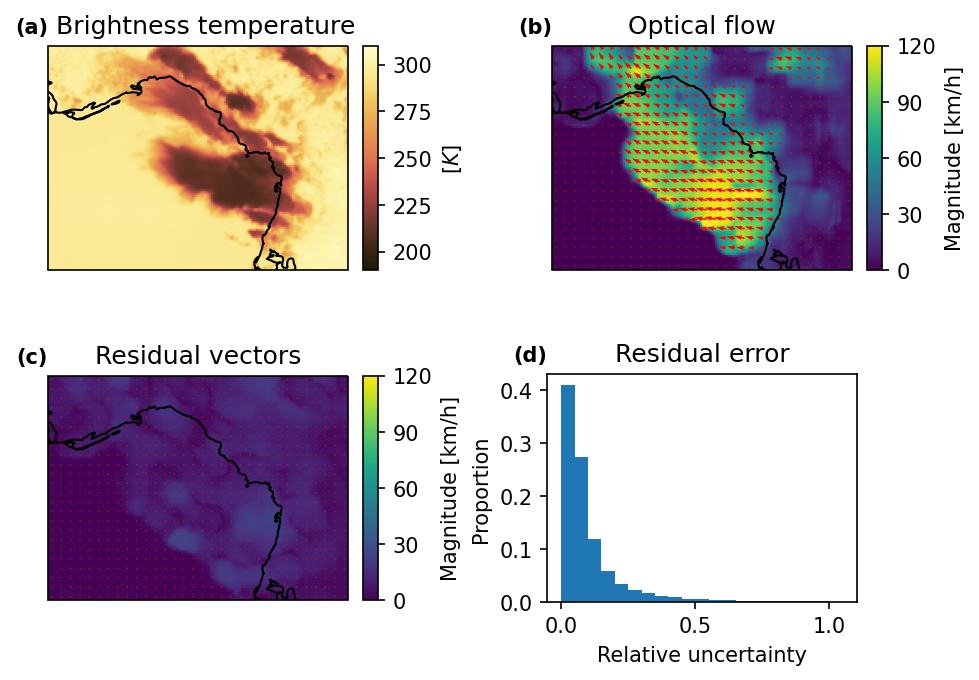

In [35]:
fig = goes_figure(ds.isel(slice_dict), dpi=dpi, figsize=(6.4,6))

from matplotlib.gridspec import GridSpec
gs = GridSpec(2, 2, width_ratios=[1,1])

i=24

ax1 = fig.subplot(gs[0,0])
ax1.coastlines()
im1 = ax1.imshow(bt[i,slice(y0,y1),slice(x0,x1)], cmap=cm_BT, vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('[$K$]', fontsize=10)
ax1.set_title('(a)', loc='left', ha="right", weight="bold", fontsize=10)
ax1.set_title('  Brightness temperature', fontsize=12)

ax1 = fig.subplot(gs[0,1])
ax1.coastlines()
img = ax1.imshow(np.maximum(flow.flow_magnitude(flows["Farneback"])[i,slice(y0,y1),slice(x0,x1)], 0), vmin=0, vmax=4)
cbar = ax1.colorbar(img)
cbar.set_label('Magnitude [km/h]', fontsize=10)
cbar.ax.set_yticklabels([0,30,60,90,120])
q = ax1.quiver(
    flows["Farneback"].forward_flow[i,slice(y0,y1),slice(x0,x1),0], 
    -flows["Farneback"].forward_flow[i,slice(y0,y1),slice(x0,x1),1], 
    spacing=5, block_method="reduce", scale=100, width=0.005, color='r'
)
ax1.set_title('Optical flow', fontsize=12)
ax1.set_title('(b)', loc='left', ha="right", weight="bold", fontsize=10)

residual_flow = ma.array(
    flow_residual_vectors, 
    mask=np.logical_or(
        np.tile(np.logical_or(
            np.isnan(flow.get_forward_warp(bt, flows["Farneback"])), 
            bt.data>270)[...,np.newaxis], (1,1,1,2)), 
        np.isnan(flow_residual_vectors)
    )
)
residual_flow_magnitudes = ma.array(
    (residual_flow.data[...,0]**2 + residual_flow.data[...,1]**2)**0.5,
    mask = np.logical_or(
        np.isnan(flow.get_forward_warp(bt, flows["Farneback"])), 
        bt.data>270
    )
)
relative_residual_flow_magnitudes = residual_flow_magnitudes/flow.flow_magnitude(flows["Farneback"])

ax1 = fig.subplot(gs[1,0])
ax1.coastlines()
img = ax1.imshow(np.fmax(residual_flow_magnitudes.data[i,slice(y0,y1),slice(x0,x1)]**0.5, 0), vmin=0, vmax=4)
cbar = ax1.colorbar(img)
cbar.set_label('Magnitude [km/h]', fontsize=10)
cbar.ax.set_yticklabels([0,30,60,90,120])
q = ax1.quiver(
    flow_residual_vectors[i,slice(y0,y1),slice(x0,x1),0], 
    -flow_residual_vectors[i,slice(y0,y1),slice(x0,x1),1], 
    spacing=5, block_method="reduce", scale=100, width=0.005, color='r'
)
ax1.set_title('Residual vectors', fontsize=12)
ax1.set_title('(c)', loc='left', ha="right", weight="bold", fontsize=10)

ax = fig.subplot(gs[1,1])

plt.subplots_adjust(hspace=0.1, wspace=0.4, bottom=0.25, top=0.95, left=0.05, right=0.95)

box = ax.get_position()
ax4 = plt.axes([box.x0+box.width*0.07, box.y0+box.height*0.12, box.width*0.86, box.height*0.76])
h = ax4.hist(
    relative_residual_flow_magnitudes[~relative_residual_flow_magnitudes.mask], 
    weights=np.full_like(
        relative_residual_flow_magnitudes[~relative_residual_flow_magnitudes.mask], 
        1/relative_residual_flow_magnitudes[~relative_residual_flow_magnitudes.mask].size
    ), 
    bins=np.arange(0,1.1,0.05))
ax4.set_title('(d)', loc='left', ha="right", weight="bold", fontsize=10)
ax4.set_title('Residual error')
ax4.set_xlabel("Relative uncertainty")
ax4.set_ylabel("Proportion")

In [36]:
figure_list.append(fig)

In [37]:
# Residual uncertainty in optical flow vectors
print("mean:", np.nanmean(relative_residual_flow_magnitudes))
print("median:", np.median(relative_residual_flow_magnitudes[~relative_residual_flow_magnitudes.mask]))

mean: 0.12489874
median: 0.06273163855075836


## Figure 15: Lagrangian convolution kernel

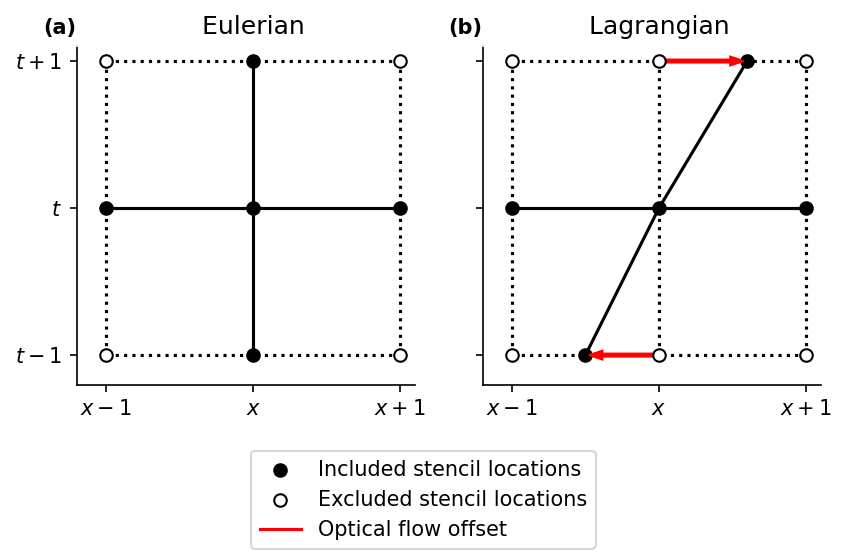

In [38]:
fig = plt.figure(dpi=dpi, figsize=(6.4,4))

ax1 = plt.subplot(121)
ax1.spines['top'].set_color('white')
ax1.spines['right'].set_color('white')
plt.plot([1,-1],[0,0],'k-')
plt.plot([0,0],[1,-1],'k-')
plt.plot([1,-1],[1,1],'k:')
plt.plot([1,-1],[-1,-1],'k:')
plt.plot([1,1],[1,-1],'k:')
plt.plot([-1,-1],[1,-1],'k:')

include_points = plt.scatter([0,0,0,1,-1],[-1,0,1,0,0], c='k', zorder=3)
exclude_points = plt.scatter([1,1,-1,-1],[1,-1,-1,1], c='white', edgecolors='k', zorder=5)

plt.xticks([-1,0,1], labels=['$x-1$', '$x$', '$x+1$'])
plt.yticks([-1,0,1], labels=['$t-1$', '$t$', '$t+1$'])

ax1.set_title('(a)', loc='left', ha="right", weight="bold", fontsize=10)
ax1.set_title('  Eulerian')

ax2 = plt.subplot(122)
ax2.spines['top'].set_color('white')
ax2.spines['right'].set_color('white')
plt.plot([1,-1],[0,0],'k-')
plt.plot([0.6,0,-0.5],[1,0,-1],'k-')
plt.plot([0,0],[1,-1],'k:')
plt.plot([1,-1],[1,1],'k:')
plt.plot([1,-1],[-1,-1],'k:')
plt.plot([1,1],[1,-1],'k:')
plt.plot([-1,-1],[1,-1],'k:')

plt.scatter([-0.5,0,0.6,1,-1],[-1,0,1,0,0], c='k', zorder=3)
plt.scatter([1,1,-1,-1,0,0],[1,-1,-1,1,1,-1], c='white', edgecolors='k', zorder=5)

offset_arrow = plt.arrow(0,-1,-0.475,0,color='r',zorder=4, width=0.02, length_includes_head=True)
plt.arrow(0,1,0.575,0,color='r',zorder=4, width=0.02, length_includes_head=True)

plt.xticks([-1,0,1], labels=['$x-1$', '$x$', '$x+1$'])
plt.yticks([-1,0,1], labels=['', '', ''])

ax2.set_title('(b)', loc='left', ha="right", weight="bold", fontsize=10)
ax2.set_title('  Lagrangian')

ax1.set_aspect("equal")
ax2.set_aspect("equal")

ax1.set_xlim([-1.2,1.1])
ax1.set_ylim([-1.2,1.1])
ax2.set_xlim([-1.2,1.1])
ax2.set_ylim([-1.2,1.1])

fig.legend([include_points, exclude_points, mlines.Line2D([], [], color='r', linestyle='-')], 
           ['Included stencil locations', 'Excluded stencil locations', 'Optical flow offset'], 
           loc='lower center')

plt.subplots_adjust(bottom=0.25, wspace=0.2)


In [39]:
figure_list.append(fig)

## Figure 16: Growing core detection

In [40]:
# Get growth_rate of the wvd field and find markers
from tobac_flow.detection import get_growth_rate, get_combined_filters
flow = flows["Farneback"]

wvd_growth = get_growth_rate(flow, wvd, method="cubic")
bt_growth = get_growth_rate(flow, -bt, method="cubic")

growth_filter = get_combined_filters(flow, bt, wvd, swd)

bt_growth *= growth_filter
wvd_growth *= growth_filter

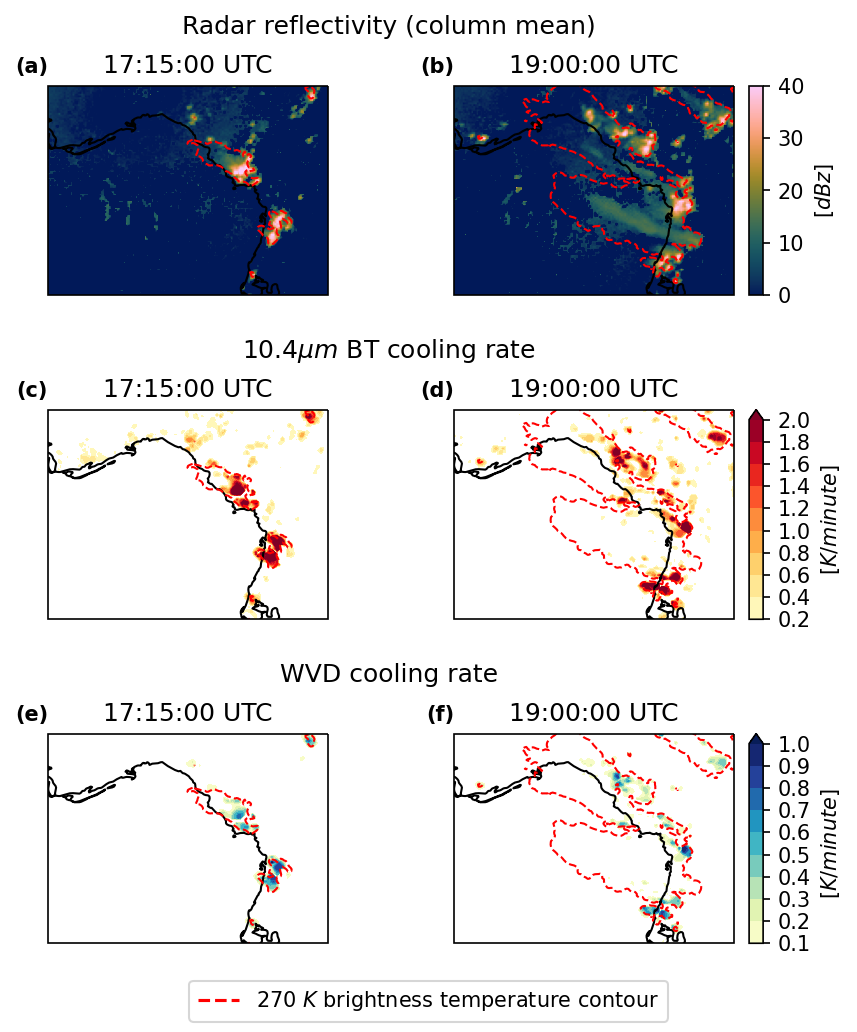

In [41]:
fig = goes_figure(ds.isel(slice_dict), dpi=dpi, figsize=(6.4,7.2))

i1=3
i2=24

ax1 = fig.subplot(321)
ax1.coastlines()
ax1.set_title('(a)', loc='left', ha="right", weight="bold", fontsize=10)
ax1.set_title('17:15:00 UTC')
ax1.contour(bt[i1].isel(slice_dict), [270], colors=['r'], linestyles=['--'], linewidths=1)
ax1.imshow(ref_grid[i1].isel(slice_dict), vmin=0, vmax=40, cmap=cm_radar)

ax2 = fig.subplot(322)
ax2.coastlines()
ax2.set_title('(b)', loc='left', ha="right", weight="bold", fontsize=10)
ax2.set_title('19:00:00 UTC')
ax2.contour(bt[i2].isel(slice_dict), [270], colors=['r'], linestyles=['--'], linewidths=1)
radar_img = ax2.imshow(ref_grid[i2].isel(slice_dict), vmin=0, vmax=40, cmap=cm_radar)
cbar = ax2.colorbar(radar_img)
cbar.set_label('[$dBz$]')

ax3 = fig.subplot(323)
ax3.coastlines()
ax3.set_title('(c)', loc='left', ha="right", weight="bold", fontsize=10)
ax3.set_title('17:15:00 UTC')
ax3.contour(bt[i1].isel(slice_dict), [270], colors=['r'], linestyles=['--'], linewidths=1)
ax3.contourf(
    bt_growth[i1, slice_dict["y"], slice_dict["x"]], 
    np.arange(0.2,2.1,0.2), extend='max', cmap='YlOrRd'
)

ax4 = fig.subplot(324)
ax4.coastlines()
ax4.set_title('(d)', loc='left', ha="right", weight="bold", fontsize=10)
ax4.set_title('19:00:00 UTC')
ax4.contour(bt[i2].isel(slice_dict), [270], colors=['r'], linestyles=['--'], linewidths=1)
bt_growth_img = ax4.contourf(
    bt_growth[i2, slice_dict["y"], slice_dict["x"]], 
    np.arange(0.2,2.1,0.2), extend='max', cmap='YlOrRd'
)
cbar = ax4.colorbar(bt_growth_img)
cbar.set_label('[$K/minute$]')

ax5 = fig.subplot(325)
ax5.coastlines()
ax5.set_title('(e)', loc='left', ha="right", weight="bold", fontsize=10)
ax5.set_title('17:15:00 UTC')
ax5.contour(bt[i1].isel(slice_dict), [270], colors=['r'], linestyles=['--'], linewidths=1)
ax5.contourf(
    wvd_growth[i1, slice_dict["y"], slice_dict["x"]], 
    np.arange(0.1,1.1,0.1), extend='max', cmap='YlGnBu'
)

ax6 = fig.subplot(326)
ax6.coastlines()
ax6.set_title('(f)', loc='left', ha="right", weight="bold", fontsize=10)
ax6.set_title('19:00:00 UTC')
ax6.contour(bt[i2].isel(slice_dict), [270], colors=['r'], linestyles=['--'], linewidths=1)
wvd_growth_img = ax6.contourf(
    wvd_growth[i2, slice_dict["y"], slice_dict["x"]], 
    np.arange(0.1,1.1,0.1), extend='max', cmap='YlGnBu'
)
cbar = ax6.colorbar(wvd_growth_img)
cbar.set_label('[$K/minute$]')

fig.text(0.51, 0.92, 'Radar reflectivity (column mean)', ha='center', va='baseline', fontsize=12)
fig.text(0.51, 0.62, '10.4$\mu m$ BT cooling rate', ha='center', va='baseline', fontsize=12)
fig.text(0.51, 0.32, 'WVD cooling rate', ha='center', va='baseline', fontsize=12)

fig.legend([mlines.Line2D([], [], color='r', linestyle='--')], 
           ['270 $K$ brightness temperature contour'], loc='lower center')

plt.subplots_adjust(wspace=0.2, top=0.9, bottom=0.05)


In [42]:
figure_list.append(fig)

In [66]:
from tobac_flow.detection import detect_cores
core_labels = detect_cores(
    flow,
    bt,
    wvd,
    swd,
    wvd_threshold=0.4,
    bt_threshold=0.8,
    overlap=0.5,
    subsegment_shrink=0.0,
    min_length=3,
)

print('Detected cores: area =', np.sum(core_labels!=0))
print('Detected cores: n =', core_labels.max())

WVD growth above threshold: area = 13339
BT growth above threshold: area = 38052
Detected markers: area = 28841


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Initial core count: 242
Core labels meeting length threshold: 56
Core labels meeting WVD threshold: 120
Core labels meeting cooling rate threshold: 45
Detected cores: area = 25830
Detected cores: n = 45


## Figure 17: Anvil edge detection

In [44]:
from tobac_flow.utils import linearise_field

upper_threshold=-5
lower_threshold=-12.5

inner_field = wvd-swd

inner_field = np.maximum(np.minimum(inner_field, upper_threshold), lower_threshold)

inner_edges = flow.sobel(
    linearise_field(inner_field, lower_threshold, upper_threshold), 
    direction="uphill", method="cubic"
)

In [45]:
upper_threshold=0
lower_threshold=-7.5

outer_field = wvd+swd

outer_field = np.maximum(np.minimum(outer_field, upper_threshold), lower_threshold)

outer_edges = flow.sobel(
    linearise_field(outer_field, lower_threshold, upper_threshold), 
    direction="uphill", method="cubic"
)

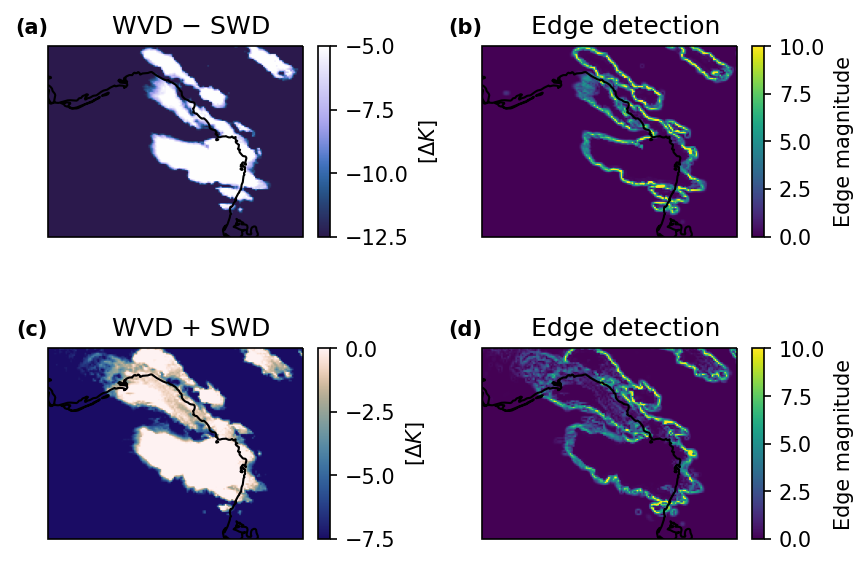

In [46]:
fig = goes_figure(ds.isel(slice_dict), dpi=dpi, figsize=(6.4,4.8))

ax1 = fig.subplot(221)
ax1.coastlines()
img1 = ax1.imshow(inner_field[24, slice_dict["y"], slice_dict["x"]], vmin=-12.5, vmax=-5, cmap=cm_WVD)
cbar = ax1.colorbar(img1)
cbar.set_label('[$\Delta K$]')
cbar.ax.set_yticks([-5,-7.5,-10.,-12.5])
ax1.set_title('(a)', loc='left', ha="right", weight="bold", fontsize=10)
ax1.set_title('    WVD $-$ SWD')


ax2 = fig.subplot(222)
ax2.coastlines()
img2 = ax2.imshow(inner_edges[24, slice_dict["y"], slice_dict["x"]], vmin=0, vmax=10)
cbar = ax2.colorbar(img2)
cbar.set_label('Edge magnitude')
ax2.set_title('(b)', loc='left', ha="right", weight="bold", fontsize=10)
ax2.set_title('    Edge detection')

ax3 = fig.subplot(223)
ax3.coastlines()
img3 = ax3.imshow(outer_field[24, slice_dict["y"], slice_dict["x"]], vmin=-7.5, vmax=0, cmap=cm_SWD)
cbar = ax3.colorbar(img3)
cbar.set_label('[$\Delta K$]')
cbar.ax.set_yticks([0,-2.5,-5,-7.5])
ax3.set_title('(c)', loc='left', ha="right", weight="bold", fontsize=10)
ax3.set_title('    WVD $+$ SWD')


ax4 = fig.subplot(224)
ax4.coastlines()
img4 = ax4.imshow(outer_edges[24, slice_dict["y"], slice_dict["x"]], vmin=0, vmax=10)
cbar = ax4.colorbar(img4)
cbar.set_label('Edge magnitude')
ax4.set_title('(d)', loc='left', ha="right", weight="bold", fontsize=10)
ax4.set_title('    Edge detection')

plt.subplots_adjust(wspace=0.4)

In [47]:
figure_list.append(fig)

## Figure 18: Example combined detection

In [48]:
# Watershed anvil regions connected to growth markers
from tobac_flow.detection import get_anvil_markers, detect_anvils, relabel_anvils

overlap = 0.5
subsegment_shrink = 0
t_offset = 3

print(datetime.now(), "Detecting thick anvil region", flush=True)
# Detect anvil regions
upper_threshold = -5
lower_threshold = -12.5
erode_distance = 2

anvil_markers = get_anvil_markers(
    flow,
    wvd - swd,
    threshold=upper_threshold,
    overlap=overlap,
    subsegment_shrink=subsegment_shrink,
    min_length=t_offset,
)

print("Final thick anvil markers: area =", np.sum(anvil_markers != 0), flush=True)
print("Final thick anvil markers: n =", anvil_markers.max(), flush=True)

thick_anvil_labels = detect_anvils(
    flow,
    wvd - swd,
    markers=anvil_markers,
    upper_threshold=upper_threshold,
    lower_threshold=lower_threshold,
    erode_distance=erode_distance,
    min_length=t_offset,
)

print(
    "Initial detected thick anvils: area =",
    np.sum(thick_anvil_labels != 0),
    flush=True,
)
print("Initial detected thick anvils: n =", thick_anvil_labels.max(), flush=True)

thick_anvil_labels = relabel_anvils(
    flow,
    thick_anvil_labels,
    markers=anvil_markers,
    overlap=overlap,
    min_length=t_offset,
)

print(
    "Final detected thick anvils: area =",
    np.sum(thick_anvil_labels != 0),
    flush=True,
)
print("Final detected thick anvils: n =", thick_anvil_labels.max(), flush=True)

print(datetime.now(), "Detecting thin anvil region", flush=True)
# Detect thin anvil regions
upper_threshold = 0
lower_threshold = -7.5

thin_anvil_labels = detect_anvils(
    flow,
    wvd + swd,
    markers=thick_anvil_labels,
    upper_threshold=upper_threshold,
    lower_threshold=lower_threshold,
    erode_distance=erode_distance,
    min_length=t_offset,
)

print("Detected thin anvils: area =", np.sum(thin_anvil_labels != 0), flush=True)
print("Detected thin anvils: n =", np.max(thin_anvil_labels), flush=True)


2023-06-05 13:02:09.278192 Detecting thick anvil region


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Final thick anvil markers: area = 108186
Final thick anvil markers: n = 16
Initial detected thick anvils: area = 194379
Initial detected thick anvils: n = 16


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Final detected thick anvils: area = 194378
Final detected thick anvils: n = 13
2023-06-05 13:02:18.347901 Detecting thin anvil region
Detected thin anvils: area = 346348
Detected thin anvils: n = 13


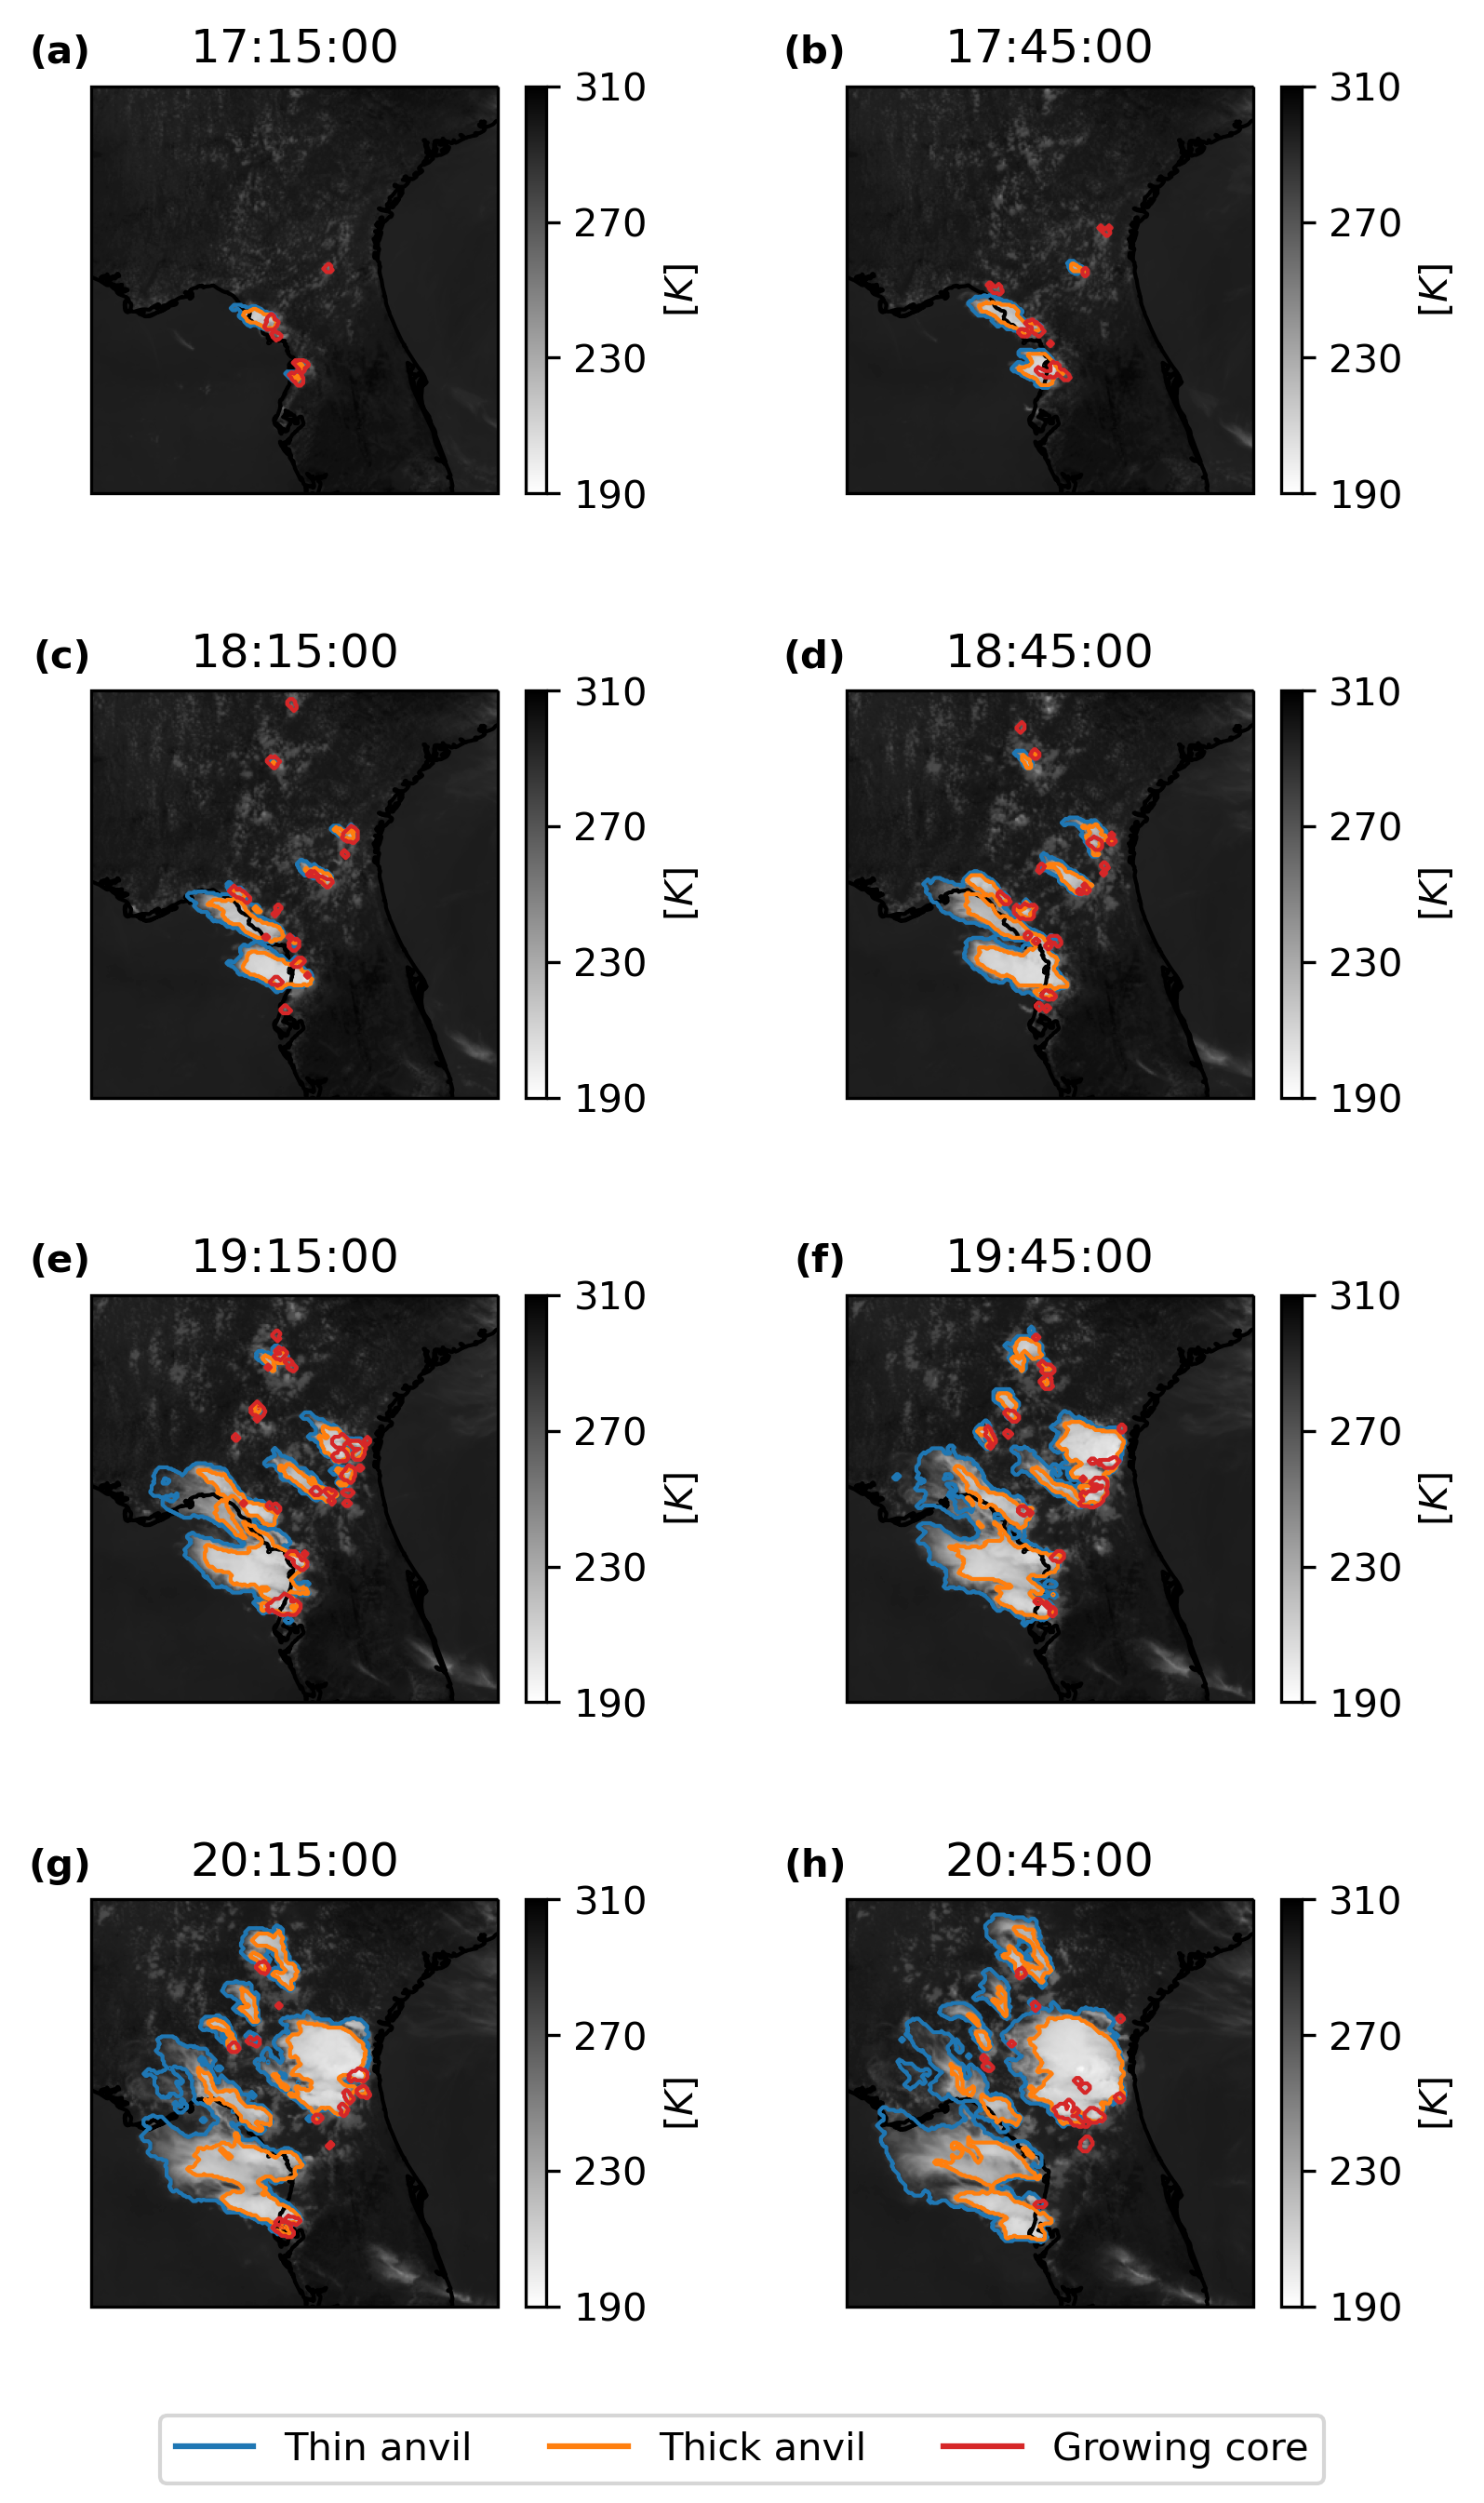

In [67]:
fig = goes_figure(ds, dpi=300, figsize=(6.4,10))

ax_list = []

times = [
    '17:15:00',
    '17:45:00',
    '18:15:00',
    '18:45:00',
    '19:15:00',
    '19:45:00',
    '20:15:00',
    '20:45:00'
]

for i, ti in enumerate(range(3,48,6)):
    ax = fig.subplot(4,2,i+1)
    
    ax.coastlines()
    img = ax.imshow(bt[ti], vmin=190, vmax=310, cmap='binary')
    
    cbar = ax.colorbar(img)
    cbar.set_label('[$K$]')
    cbar.set_ticks([190,230,270,310])
    
    ax.contour(thin_anvil_labels[ti], [0.5], colors=['C00'], linewidths=[1])
    ax.contour(thick_anvil_labels[ti], [0.5], colors=['C01'], linewidths=[1])
    ax.contour(core_labels[ti], [0.5], colors=['C03'], linewidths=[1])

    ax.set_title(f'({chr(ord("a") + i)})', loc='left', ha="right", weight="bold", fontsize=10)
    ax.set_title(f'{times[i]}')
    
    ax_list.append(ax)
    
fig.legend([mlines.Line2D([], [], color='C00'), mlines.Line2D([], [], color='C01'), mlines.Line2D([], [], color='C03')], 
           ['Thin anvil', 'Thick anvil', 'Growing core'], loc='lower center', ncol=3)

plt.subplots_adjust(bottom=0.05)

In [50]:
figure_list.append(fig)

## Figure 19: Validation results

Text(0.0, 1.0, '(c)')

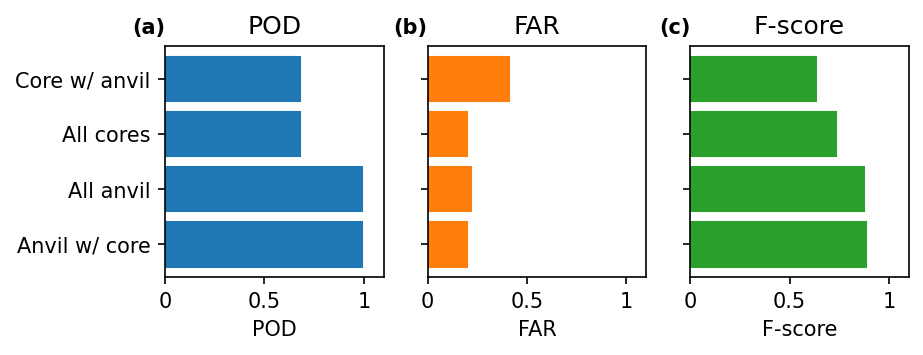

In [51]:
pod = np.array([0.68, 0.68, 0.99, 0.99])
far = np.array([0.41, 0.20, 0.22, 0.20])
f_score = 2 * pod * (1 - far) / (pod + 1 - far)

fig, axs = plt.subplots(1, 3, sharey=True, dpi=dpi, figsize=(6.4,2))
fig.subplots_adjust(wspace=0.2)

axs[0].barh(range(4), pod, facecolor = 'C0', edgecolor='C0')
axs[0].set_xlim([0,1.1])
axs[0].set_xticklabels([0,0.5,1])
axs[0].set_yticks(range(4), ["Core w/ anvil", "All cores", "All anvil", "Anvil w/ core"])
axs[0].invert_yaxis()
axs[0].set_xlabel("POD")
axs[0].set_title("POD")
axs[0].set_title('(a)', loc='left', ha="right", weight="bold", fontsize=10)

axs[1].barh(range(4), far, facecolor = 'C1', edgecolor='C1')
axs[1].set_xlim([0,1.1])
axs[1].set_xticklabels([0,0.5,1])
axs[1].set_xlabel("FAR")
axs[1].set_title("FAR")
axs[1].set_title('(b)', loc='left', ha="right", weight="bold", fontsize=10)

axs[2].barh(range(4), f_score, facecolor = 'C2', edgecolor='C2')
axs[2].set_xlim([0,1.1])
axs[2].set_xticklabels([0,0.5,1])
axs[2].set_xlabel("F-score")
axs[2].set_title("F-score")
axs[2].set_title('(c)', loc='left', ha="right", weight="bold", fontsize=10)



In [52]:
figure_list.append(fig)

In [58]:
for i, fig in enumerate(figure_list):
    fig.savefig(
        save_path / f'{chapter_name}_{(i+1):02d}.{save_format}',
        bbox_inches="tight", pad_inches=0.25
    )

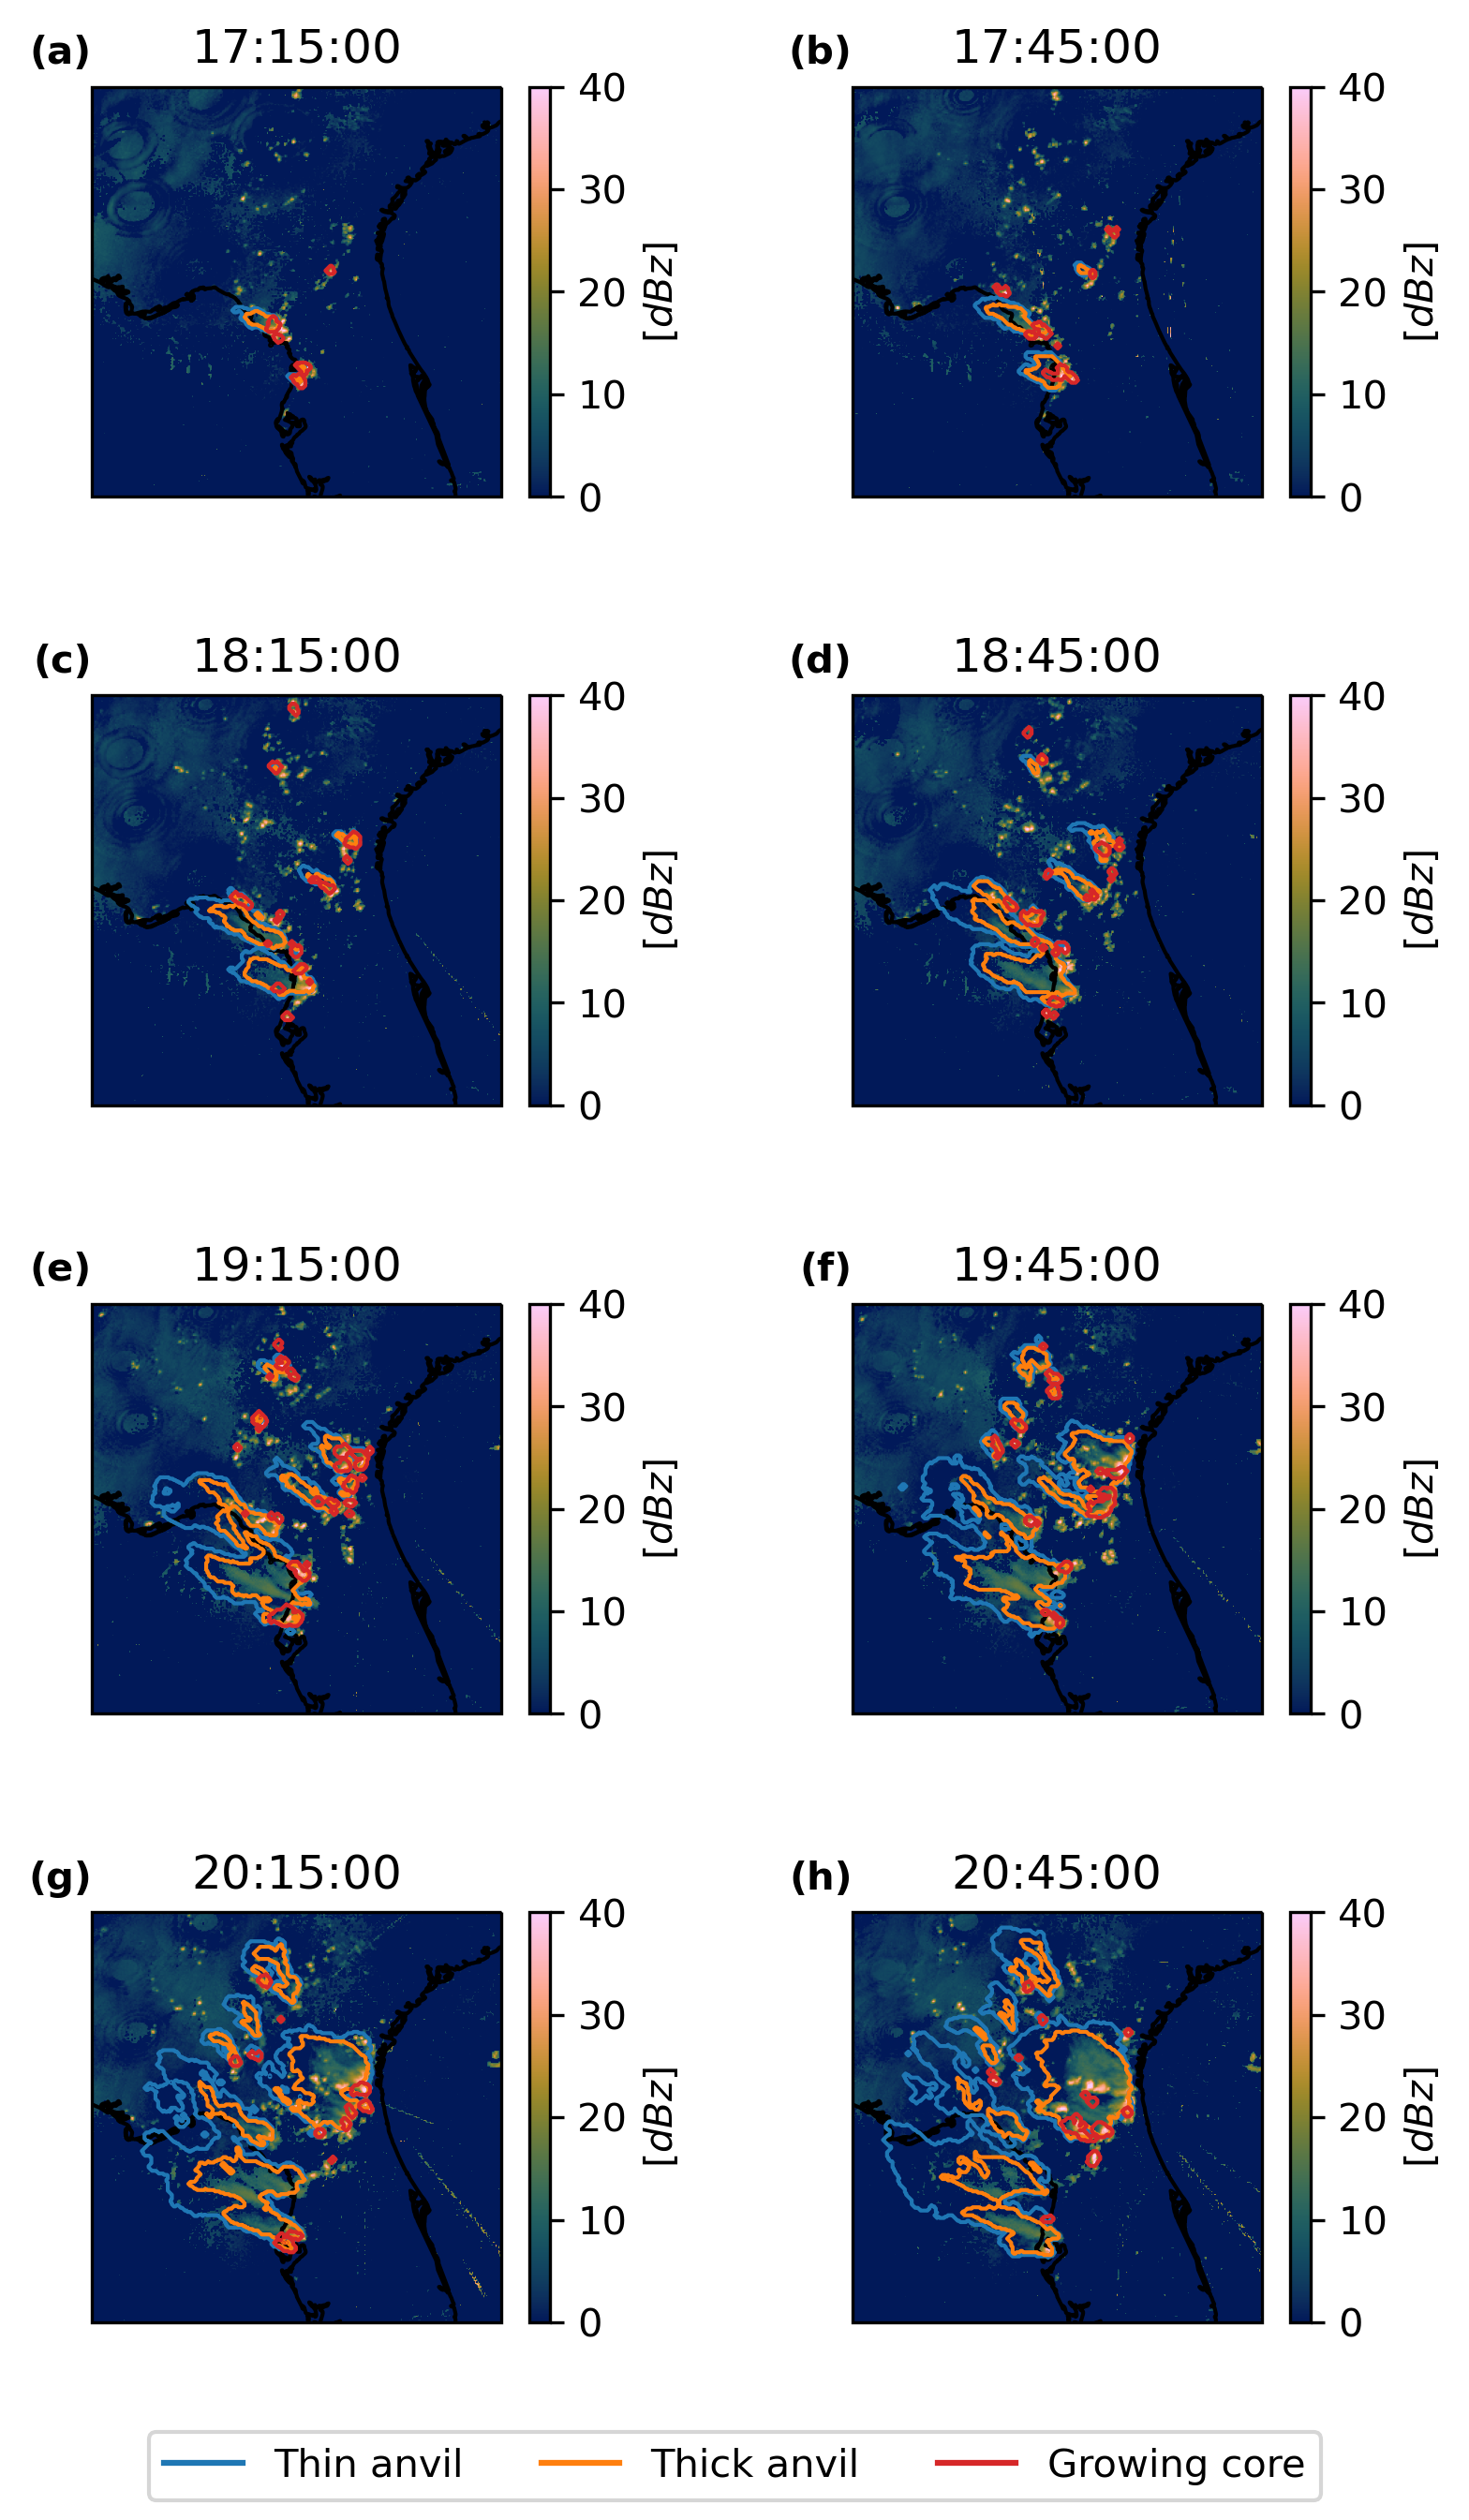

In [68]:
fig = goes_figure(ds, dpi=300, figsize=(6.4,10))

ax_list = []

times = [
    '17:15:00',
    '17:45:00',
    '18:15:00',
    '18:45:00',
    '19:15:00',
    '19:45:00',
    '20:15:00',
    '20:45:00'
]

for i, ti in enumerate(range(3,48,6)):
    ax = fig.subplot(4,2,i+1)
    
    ax.coastlines()
    img = ax.imshow(ref_grid[ti], vmin=0, vmax=40, cmap=cm_radar)
    
    cbar = ax.colorbar(img)
    cbar.set_label('[$dBz$]')
#     cbar.set_ticks([190,230,270,310])
    
    ax.contour(thin_anvil_labels[ti], [0.5], colors=['C00'], linewidths=[1])
    ax.contour(thick_anvil_labels[ti], [0.5], colors=['C01'], linewidths=[1])
    ax.contour(core_labels[ti], [0.5], colors=['C03'], linewidths=[1])

    ax.set_title(f'({chr(ord("a") + i)})', loc='left', ha="right", weight="bold", fontsize=10)
    ax.set_title(f'{times[i]}')
    
    ax_list.append(ax)
    
fig.legend([mlines.Line2D([], [], color='C00'), mlines.Line2D([], [], color='C01'), mlines.Line2D([], [], color='C03')], 
           ['Thin anvil', 'Thick anvil', 'Growing core'], loc='lower center', ncol=3)

plt.subplots_adjust(bottom=0.05)

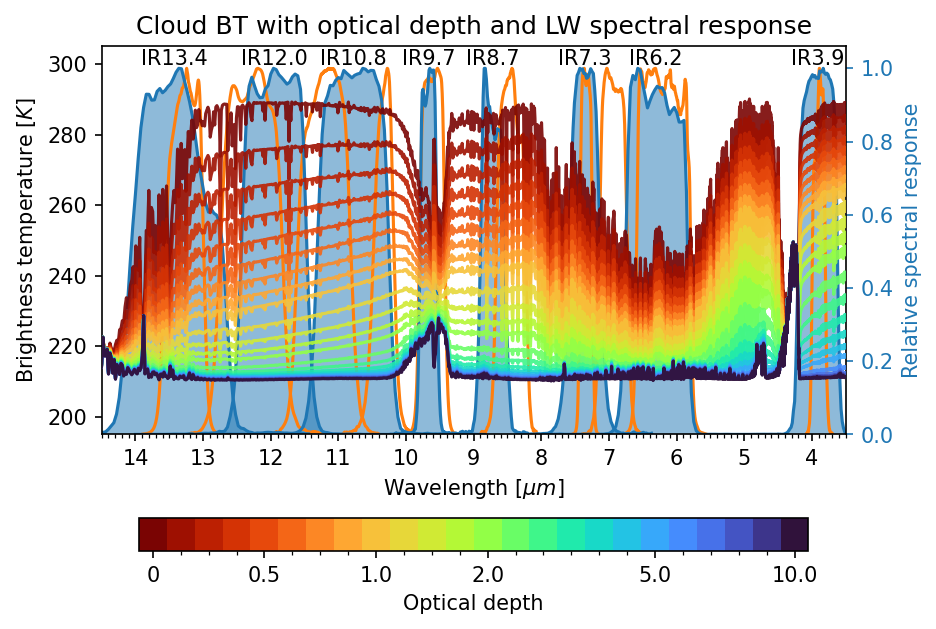

In [107]:
fig, ax1 = plt.subplots(dpi=dpi)

cmap = matplotlib.cm.turbo_r
bounds = np.arange(-0.5,theory_ds.optical_depth.size).tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

for i in range(theory_ds.optical_depth.size):
    ax1.plot(
        theory_ds.wavelength*1e9, 
        theory_ds.cloud_od_brightness_temperature[i],
        c=cmap(norm(i)), alpha=0.9
    )

plt.ylim([195,305])
plt.xticks((np.arange(3000,15001,1000)), np.arange(3,16))
ax1.xaxis.set_ticks(np.arange(3000,15001,100), minor=True)
plt.xlim((14500), (3500))
plt.xlabel("Wavelength [$\mu m$]")
plt.ylabel("Brightness temperature [$K$]")

ax2 = ax1.twinx()

abi_rsr = RelativeSpectralResponse('GOES-16', 'abi')

for band in ['ch7','ch8','ch9','ch10','ch11','ch12','ch13','ch14','ch15','ch16']:
    rsr = abi_rsr.rsr[band]["det-1"]
    plt.plot((rsr["wavelength"]*1e3), rsr["response"], "C1")
#     plt.fill_between((rsr["wavelength"]*1e3), rsr["response"], facecolor="C1", alpha=0.5)
#     plt.text((rsr["central_wavelength"]*1e3), 1.01, band[2:], ha="center")

seviri_rsr = RelativeSpectralResponse('Meteosat-11', 'seviri')

for band in ['IR8.7', 'IR7.3', 'IR13.4', 'IR6.2', 'IR12.0', 'IR10.8', 'IR9.7', 'IR3.9']:
    rsr = seviri_rsr.rsr[band]["det-1"]
    plt.plot((rsr["wavelength"]*1e3), rsr["response"], "C0")
    plt.fill_between((rsr["wavelength"]*1e3), rsr["response"], facecolor="C0", alpha=0.5)
    plt.text((rsr["central_wavelength"]*1e3), 1.01, band, ha="center")

plt.ylim([0,1.06])
plt.ylabel("Relative spectral response")
ax2.yaxis.label.set_color('C0')
ax2.tick_params(axis='y', colors='C0')

ax2.set_zorder(ax2.get_zorder()-1)
ax1.set_frame_on(False)
ax2.set_frame_on(True)

plt.title("Cloud BT with optical depth and LW spectral response")

cbar = fig.colorbar(
    matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), 
    orientation="horizontal", label="Optical depth", 
    ax=plt.gca(), shrink=0.9
)
odticks = [0,4,8,12,18,23]
odlabels = [0] + [theory_ds.optical_depth.to_numpy()[i] for i in odticks[1:]]
major_ticks = cbar.ax.xaxis.set_ticks(odticks, odlabels)
minor_ticks = cbar.ax.xaxis.set_ticks(np.arange(0,theory_ds.optical_depth.size,1), minor=True)

In [79]:
seviri_rsr.rsr.keys()

dict_keys(['VIS0.6', 'IR8.7', 'IR7.3', 'IR13.4', 'VIS0.8', 'HRV', 'IR6.2', 'IR12.0', 'IR10.8', 'NIR1.6', 'IR9.7', 'IR3.9'])

Text(0.5, 0, 'Optical depth')

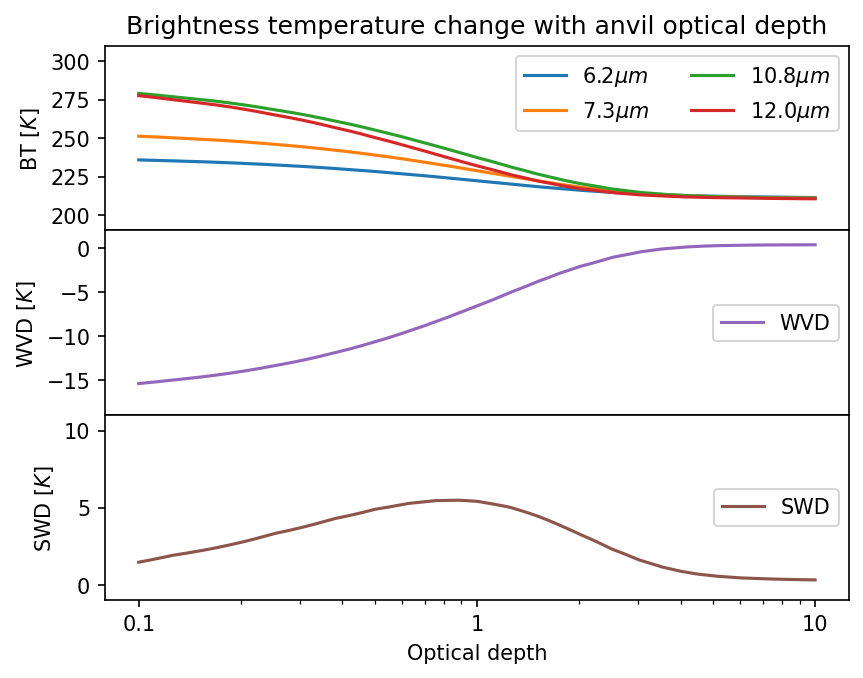

In [90]:
bt_funcs = []
for i in range(theory_ds.optical_depth.size):
    bt_funcs.append(scipy.interpolate.interp1d(
        theory_ds.wavelength, theory_ds.cloud_od_brightness_temperature[i]
    ))

bt_by_channel = {}
for band in ['IR8.7', 'IR7.3', 'IR6.2', 'IR12.0', 'IR10.8', 'IR9.7', 'IR3.9', 'IR13.4']:
    rsr = seviri_rsr.rsr[band]["det-1"]
    wavelengths = rsr["wavelength"]/1e6
    wh = np.logical_and(wavelengths > 3e-6, wavelengths < 15e-6)
    srf = rsr["response"]
    bt_by_channel[band] = [np.average(bt(wavelengths[wh]), weights=srf[wh]) for bt in bt_funcs]

bt_od_func = {band:scipy.interpolate.interp1d(
    theory_ds.optical_depth, bt_by_channel[band]
) for band in ['IR8.7', 'IR7.3', 'IR6.2', 'IR12.0', 'IR10.8', 'IR9.7', 'IR3.9', 'IR13.4']}

fig, axs = plt.subplots(3, 1, sharex=True, dpi=dpi)
# Remove vertical space between axes
fig.subplots_adjust(hspace=0)

xlocs = np.linspace(np.log(0.1), np.log(10), 1000)
xvals = np.minimum(np.exp(xlocs), 10)
# Plot each graph, and manually set the y tick values
for i, band in enumerate(['IR6.2','IR7.3','IR10.8','IR12.0']):
    axs[0].plot(xlocs, bt_od_func[band](xvals))
axs[0].set_ylabel("BT [$K$]")
axs[0].legend(['$6.2\mu m$','$7.3\mu m$','$10.8\mu m$','$12.0\mu m$'], ncol=2)
axs[0].set_ylim([190,310])
axs[0].set_yticks(range(200,301,25))

wvd_od = bt_od_func["IR6.2"](xvals) - bt_od_func["IR7.3"](xvals)
axs[1].plot(xlocs, wvd_od,"C4")
axs[1].set_ylabel("WVD [$K$]")
axs[1].set_yticks(range(-15,1,5))
axs[1].set_ylim([-19,2])
axs[1].legend(["WVD"], loc="right")

swd_od = bt_od_func["IR10.8"](xvals) - bt_od_func["IR12.0"](xvals)
axs[2].plot(xlocs, swd_od,"C5")
axs[2].set_ylabel("SWD [$K$]")
axs[2].set_ylim([-1,11])
axs[2].legend(["SWD"], loc="right")

axs[0].set_title("Brightness temperature change with anvil optical depth")
plt.xticks([np.log(0.1), np.log(1), np.log(10)], [0.1, 1, 10])
plt.xticks(np.log(np.arange(0.1,1,0.1)).tolist() + np.log(np.arange(1,11,1)).tolist(), minor=True)
plt.xlabel("Optical depth")

Text(0.5, 0, 'Optical depth')

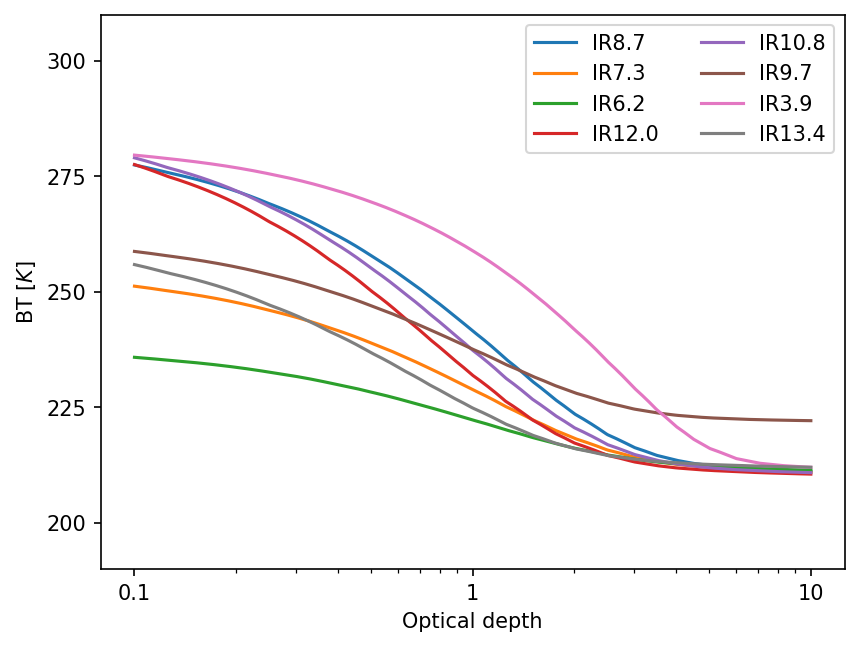

In [93]:
fig, axs = plt.subplots(1, 1, sharex=True, dpi=dpi)
# Remove vertical space between axes
fig.subplots_adjust(hspace=0)

xlocs = np.linspace(np.log(0.1), np.log(10), 1000)
xvals = np.minimum(np.exp(xlocs), 10)
# Plot each graph, and manually set the y tick values
for i, band in enumerate(['IR8.7', 'IR7.3', 'IR6.2', 'IR12.0', 'IR10.8', 'IR9.7', 'IR3.9', 'IR13.4']):
    axs.plot(xlocs, bt_od_func[band](xvals))
axs.set_ylabel("BT [$K$]")
axs.legend(['IR8.7', 'IR7.3', 'IR6.2', 'IR12.0', 'IR10.8', 'IR9.7', 'IR3.9', 'IR13.4'], ncol=2)
axs.set_ylim([190,310])
axs.set_yticks(range(200,301,25))
plt.xticks([np.log(0.1), np.log(1), np.log(10)], [0.1, 1, 10])
plt.xticks(np.log(np.arange(0.1,1,0.1)).tolist() + np.log(np.arange(1,11,1)).tolist(), minor=True)
plt.xlabel("Optical depth")

Text(0.5, 0, 'Optical depth')

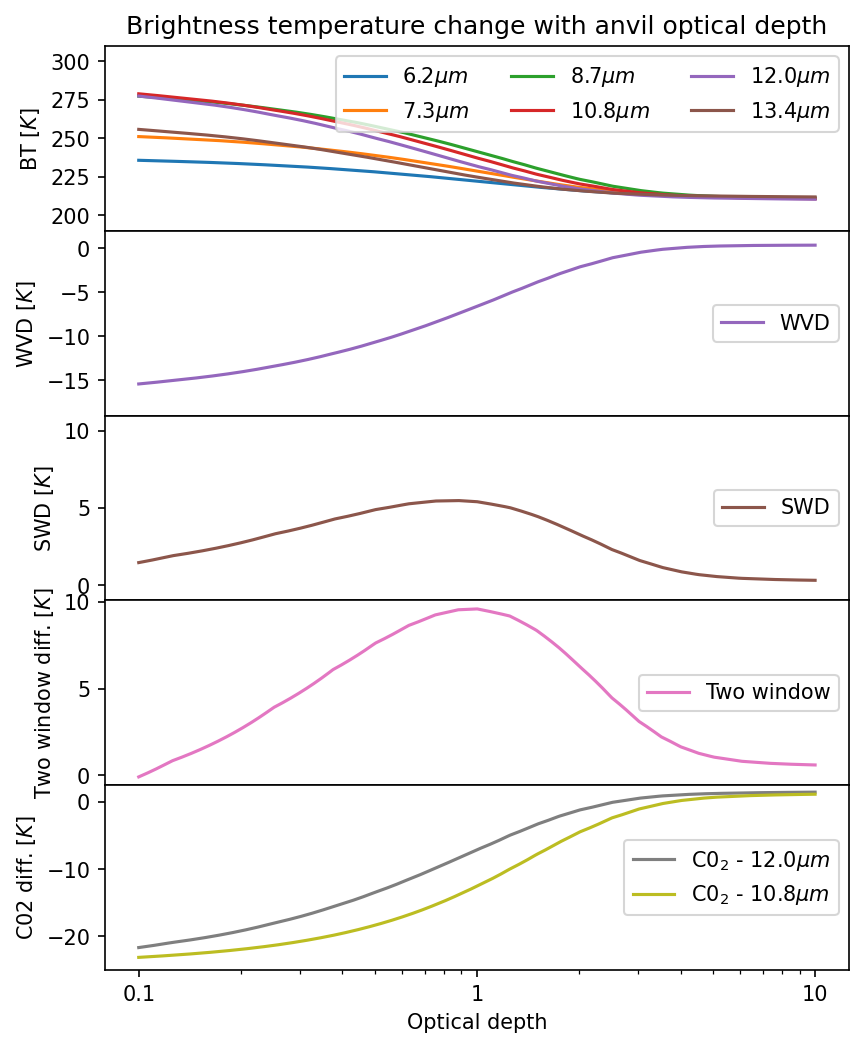

In [100]:
bt_funcs = []
for i in range(theory_ds.optical_depth.size):
    bt_funcs.append(scipy.interpolate.interp1d(
        theory_ds.wavelength, theory_ds.cloud_od_brightness_temperature[i]
    ))

bt_by_channel = {}
for band in ['IR8.7', 'IR7.3', 'IR6.2', 'IR12.0', 'IR10.8', 'IR9.7', 'IR3.9', 'IR13.4']:
    rsr = seviri_rsr.rsr[band]["det-1"]
    wavelengths = rsr["wavelength"]/1e6
    wh = np.logical_and(wavelengths > 3e-6, wavelengths < 15e-6)
    srf = rsr["response"]
    bt_by_channel[band] = [np.average(bt(wavelengths[wh]), weights=srf[wh]) for bt in bt_funcs]

bt_od_func = {band:scipy.interpolate.interp1d(
    theory_ds.optical_depth, bt_by_channel[band]
) for band in ['IR8.7', 'IR7.3', 'IR6.2', 'IR12.0', 'IR10.8', 'IR9.7', 'IR3.9', 'IR13.4']}

fig, axs = plt.subplots(5, 1, sharex=True, dpi=dpi, figsize=(6.4,8))
# Remove vertical space between axes
fig.subplots_adjust(hspace=0)

xlocs = np.linspace(np.log(0.1), np.log(10), 1000)
xvals = np.minimum(np.exp(xlocs), 10)
# Plot each graph, and manually set the y tick values
for i, band in enumerate(['IR6.2','IR7.3',"IR8.7",'IR10.8','IR12.0', 'IR13.4']):
    axs[0].plot(xlocs, bt_od_func[band](xvals))
axs[0].set_ylabel("BT [$K$]")
axs[0].legend(['$6.2\mu m$','$7.3\mu m$','$8.7\mu m$','$10.8\mu m$','$12.0\mu m$', '$13.4\mu m$'], ncol=3)
axs[0].set_ylim([190,310])
axs[0].set_yticks(range(200,301,25))

wvd_od = bt_od_func["IR6.2"](xvals) - bt_od_func["IR7.3"](xvals)
axs[1].plot(xlocs, wvd_od,"C4")
axs[1].set_ylabel("WVD [$K$]")
axs[1].set_yticks(range(-15,1,5))
axs[1].set_ylim([-19,2])
axs[1].legend(["WVD"], loc="right")

swd_od = bt_od_func["IR10.8"](xvals) - bt_od_func["IR12.0"](xvals)
axs[2].plot(xlocs, swd_od,"C5")
axs[2].set_ylabel("SWD [$K$]")
axs[2].set_ylim([-1,11])
axs[2].legend(["SWD"], loc="right")

twd_od = bt_od_func["IR8.7"](xvals) - bt_od_func["IR12.0"](xvals)
axs[3].plot(xlocs, twd_od,"C6")
axs[3].set_ylabel("Two window diff. [$K$]")
# axs[3].set_ylim([-1,11])
axs[3].legend(["Two window"], loc="right")

co2_od = bt_od_func["IR13.4"](xvals) - bt_od_func["IR12.0"](xvals)
co2_od2 = bt_od_func["IR13.4"](xvals) - bt_od_func["IR10.8"](xvals)
axs[4].plot(xlocs, co2_od,"C7")
axs[4].plot(xlocs, co2_od2,"C8")
axs[4].set_ylabel("C02 diff. [$K$]")
axs[4].set_ylim([-25,2.5])
axs[4].legend(["C0$_2$ - $12.0 \mu m$", "C0$_2$ - $10.8 \mu m$"], loc="right")

axs[0].set_title("Brightness temperature change with anvil optical depth")
plt.xticks([np.log(0.1), np.log(1), np.log(10)], [0.1, 1, 10])
plt.xticks(np.log(np.arange(0.1,1,0.1)).tolist() + np.log(np.arange(1,11,1)).tolist(), minor=True)
plt.xlabel("Optical depth")

Text(0.5, 0, 'Optical depth')

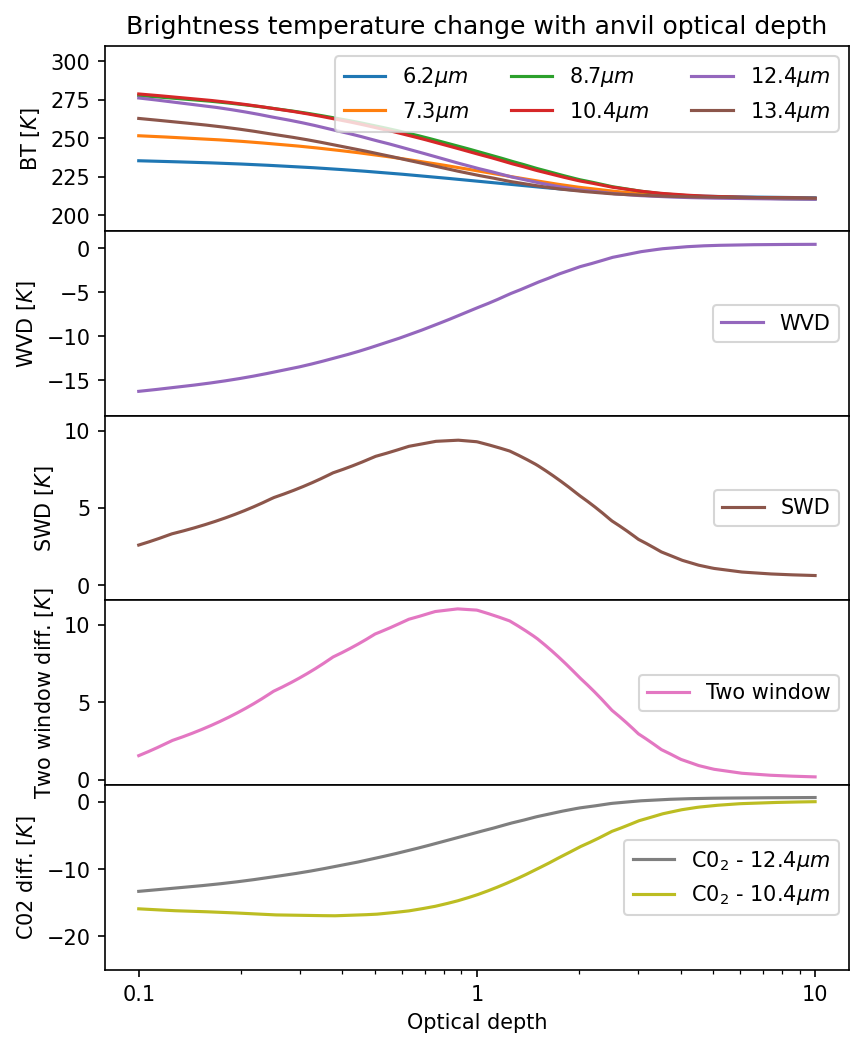

In [102]:
bt_funcs = []
for i in range(theory_ds.optical_depth.size):
    bt_funcs.append(scipy.interpolate.interp1d(
        theory_ds.wavelength, theory_ds.cloud_od_brightness_temperature[i]
    ))

bt_by_channel = {}
for band in ['ch8','ch10','ch11','ch13','ch15','ch16']:#['IR8.7', 'IR7.3', 'IR6.2', 'IR12.0', 'IR10.8', 'IR9.7', 'IR3.9', 'IR13.4']:
    rsr = abi_rsr.rsr[band]["det-1"]
    wavelengths = rsr["wavelength"]/1e6
    wh = np.logical_and(wavelengths > 3e-6, wavelengths < 15e-6)
    srf = rsr["response"]
    bt_by_channel[band] = [np.average(bt(wavelengths[wh]), weights=srf[wh]) for bt in bt_funcs]

bt_od_func = {band:scipy.interpolate.interp1d(
    theory_ds.optical_depth, bt_by_channel[band]
) for band in ['ch8','ch10','ch11','ch13','ch15','ch16']}

fig, axs = plt.subplots(5, 1, sharex=True, dpi=dpi, figsize=(6.4,8))
# Remove vertical space between axes
fig.subplots_adjust(hspace=0)

xlocs = np.linspace(np.log(0.1), np.log(10), 1000)
xvals = np.minimum(np.exp(xlocs), 10)
# Plot each graph, and manually set the y tick values
for i, band in enumerate(['ch8','ch10','ch11','ch13','ch15','ch16']):
    axs[0].plot(xlocs, bt_od_func[band](xvals))
axs[0].set_ylabel("BT [$K$]")
axs[0].legend(['$6.2\mu m$','$7.3\mu m$','$8.7\mu m$','$10.4\mu m$','$12.4\mu m$', '$13.4\mu m$'], ncol=3)
axs[0].set_ylim([190,310])
axs[0].set_yticks(range(200,301,25))

wvd_od = bt_od_func["ch8"](xvals) - bt_od_func["ch10"](xvals)
axs[1].plot(xlocs, wvd_od,"C4")
axs[1].set_ylabel("WVD [$K$]")
axs[1].set_yticks(range(-15,1,5))
axs[1].set_ylim([-19,2])
axs[1].legend(["WVD"], loc="right")

swd_od = bt_od_func["ch13"](xvals) - bt_od_func["ch15"](xvals)
axs[2].plot(xlocs, swd_od,"C5")
axs[2].set_ylabel("SWD [$K$]")
axs[2].set_ylim([-1,11])
axs[2].legend(["SWD"], loc="right")

twd_od = bt_od_func["ch11"](xvals) - bt_od_func["ch15"](xvals)
axs[3].plot(xlocs, twd_od,"C6")
axs[3].set_ylabel("Two window diff. [$K$]")
# axs[3].set_ylim([-1,11])
axs[3].legend(["Two window"], loc="right")

co2_od = bt_od_func["ch16"](xvals) - bt_od_func["ch15"](xvals)
co2_od2 = bt_od_func["ch16"](xvals) - bt_od_func["ch13"](xvals)
axs[4].plot(xlocs, co2_od,"C7")
axs[4].plot(xlocs, co2_od2,"C8")
axs[4].set_ylabel("C02 diff. [$K$]")
axs[4].set_ylim([-25,2.5])
axs[4].legend(["C0$_2$ - $12.4 \mu m$", "C0$_2$ - $10.4 \mu m$"], loc="right")

axs[0].set_title("Brightness temperature change with anvil optical depth")
plt.xticks([np.log(0.1), np.log(1), np.log(10)], [0.1, 1, 10])
plt.xticks(np.log(np.arange(0.1,1,0.1)).tolist() + np.log(np.arange(1,11,1)).tolist(), minor=True)
plt.xlabel("Optical depth")